In [ ]:
#tfidf -> w2v -> gloVe

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, plot_confusion_matrix
import nltk
import pickle

#specific to this notebook
import spacy
#!python -m spacy download en_core_web_md
import en_core_web_md
nlp = en_core_web_md.load() 

import sklearn

In [5]:
#Load in data and split for train and test sets
#df = pd.read_csv(r'C:\Users\jackc\Semester2\Project\Identifying-Hate-Speech-Categories-On-Social-Media\Data\clean_dataset.csv')
df = pd.read_csv(r'C:\Users\Jack\Desktop\proj\Identifying-Hate-Speech-Categories-On-Social-Media\Data\clean_dataset.csv')

X_train, X_test, y_train, y_test = train_test_split(df['text_lemma'], df['Hate'], test_size=0.25, random_state=12)
                                                       
df.head(5)

,id,text,Annotation,tokenized_text,text_lemma,pos_tags,Hate
0,5.969655e+17,i just found the perfect rental why cant my le...,Neither,"['found', 'perfect', 'rental', 'cant', 'lease'...","['found', 'perfect', 'rental', 'cant', 'lease'...","['i_NN', 'just_RB', 'found_VBD', 'the_DT', 'pe...",0
1,5.758918e+17,every time they discover anything its either ...,Neither,"['every', 'time', 'discover', 'anything', 'eit...","['every', 'time', 'discover', 'anything', 'eit...","['every_DT', 'time_NN', 'they_PRP', 'discover_...",0
2,5.952595e+17,ok time to write code bbl\r\n\r\nmaking a new ...,Neither,"['ok', 'time', 'write', 'code', 'bbl', 'making...","['ok', 'time', 'write', 'code', 'bbl', 'making...","['ok_JJ', 'time_NN', 'to_TO', 'write_VB', 'cod...",0
3,5.723449e+17,refined dessert not mkr,Neither,"['refined', 'dessert', 'mkr']","['refined', 'dessert', 'mkr']","['refined_VBN', 'dessert_NN', 'not_RB', 'mkr_VB']",0
4,5.681320e+17,one of the best things anyone can do to impr...,Neither,"['one', 'best', 'things', 'anyone', 'improve',...","['one', 'best', 'thing', 'anyone', 'improve', ...","['one_CD', 'of_IN', 'the_DT', 'best_JJS', 'thi...",0


# TFIDF 

## Grid SVM

In [9]:
#create TFIDF matrix
tfidf = TfidfVectorizer()
tfidf_train = tfidf.fit_transform(X_train)
tfidf_test = tfidf.transform(X_test)

In [10]:
SVM_default = svm.SVC(C=1.0, kernel='rbf', gamma='scale', shrinking=True,
                      class_weight=None, random_state=12)

# dictionary containing the parameters which will be used for grid search
grid_search_params={'C': [1, 10, 30],  
              'gamma': ['auto', 0.1, 0.01], 
              'kernel': ['rbf', 'sigmoid', 'linear', 'poly'],
              'coef0': [0.1, 1, 3],
              'degree': [1, 3, 5],
              'class_weight': [None, 'balanced']}

# grid search with f1 being the performance metric
SVM_grid = GridSearchCV(SVM_default, grid_search_params, cv=5, scoring='f1_macro', verbose=3)
SVM_grid.fit(tfidf_train, y_train)

Fitting 5 folds for each of 648 candidates, totalling 3240 fits
[CV] C=1, class_weight=None, coef0=0.1, degree=1, gamma=auto, kernel=rbf 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=1, class_weight=None, coef0=0.1, degree=1, gamma=auto, kernel=rbf, score=0.457, total=   0.6s
[CV] C=1, class_weight=None, coef0=0.1, degree=1, gamma=auto, kernel=rbf 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s


[CV]  C=1, class_weight=None, coef0=0.1, degree=1, gamma=auto, kernel=rbf, score=0.457, total=   0.6s
[CV] C=1, class_weight=None, coef0=0.1, degree=1, gamma=auto, kernel=rbf 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s


[CV]  C=1, class_weight=None, coef0=0.1, degree=1, gamma=auto, kernel=rbf, score=0.457, total=   0.6s
[CV] C=1, class_weight=None, coef0=0.1, degree=1, gamma=auto, kernel=rbf 
[CV]  C=1, class_weight=None, coef0=0.1, degree=1, gamma=auto, kernel=rbf, score=0.457, total=   0.5s
[CV] C=1, class_weight=None, coef0=0.1, degree=1, gamma=auto, kernel=rbf 
[CV]  C=1, class_weight=None, coef0=0.1, degree=1, gamma=auto, kernel=rbf, score=0.457, total=   0.5s
[CV] C=1, class_weight=None, coef0=0.1, degree=1, gamma=auto, kernel=sigmoid 
[CV]  C=1, class_weight=None, coef0=0.1, degree=1, gamma=auto, kernel=sigmoid, score=0.457, total=   0.6s
[CV] C=1, class_weight=None, coef0=0.1, degree=1, gamma=auto, kernel=sigmoid 
[CV]  C=1, class_weight=None, coef0=0.1, degree=1, gamma=auto, kernel=sigmoid, score=0.457, total=   0.6s
[CV] C=1, class_weight=None, coef0=0.1, degree=1, gamma=auto, kernel=sigmoid 
[CV]  C=1, class_weight=None, coef0=0.1, degree=1, gamma=auto, kernel=sigmoid, score=0.457, total=  

[CV]  C=1, class_weight=None, coef0=0.1, degree=1, gamma=0.01, kernel=sigmoid, score=0.457, total=   0.8s
[CV] C=1, class_weight=None, coef0=0.1, degree=1, gamma=0.01, kernel=sigmoid 
[CV]  C=1, class_weight=None, coef0=0.1, degree=1, gamma=0.01, kernel=sigmoid, score=0.457, total=   0.8s
[CV] C=1, class_weight=None, coef0=0.1, degree=1, gamma=0.01, kernel=linear 
[CV]  C=1, class_weight=None, coef0=0.1, degree=1, gamma=0.01, kernel=linear, score=0.788, total=   0.8s
[CV] C=1, class_weight=None, coef0=0.1, degree=1, gamma=0.01, kernel=linear 
[CV]  C=1, class_weight=None, coef0=0.1, degree=1, gamma=0.01, kernel=linear, score=0.793, total=   1.2s
[CV] C=1, class_weight=None, coef0=0.1, degree=1, gamma=0.01, kernel=linear 
[CV]  C=1, class_weight=None, coef0=0.1, degree=1, gamma=0.01, kernel=linear, score=0.806, total=   1.3s
[CV] C=1, class_weight=None, coef0=0.1, degree=1, gamma=0.01, kernel=linear 
[CV]  C=1, class_weight=None, coef0=0.1, degree=1, gamma=0.01, kernel=linear, score=0.8

[CV]  C=1, class_weight=None, coef0=0.1, degree=3, gamma=0.1, kernel=linear, score=0.767, total=   0.7s
[CV] C=1, class_weight=None, coef0=0.1, degree=3, gamma=0.1, kernel=poly 
[CV]  C=1, class_weight=None, coef0=0.1, degree=3, gamma=0.1, kernel=poly, score=0.457, total=   0.9s
[CV] C=1, class_weight=None, coef0=0.1, degree=3, gamma=0.1, kernel=poly 
[CV]  C=1, class_weight=None, coef0=0.1, degree=3, gamma=0.1, kernel=poly, score=0.457, total=   0.9s
[CV] C=1, class_weight=None, coef0=0.1, degree=3, gamma=0.1, kernel=poly 
[CV]  C=1, class_weight=None, coef0=0.1, degree=3, gamma=0.1, kernel=poly, score=0.457, total=   0.9s
[CV] C=1, class_weight=None, coef0=0.1, degree=3, gamma=0.1, kernel=poly 
[CV]  C=1, class_weight=None, coef0=0.1, degree=3, gamma=0.1, kernel=poly, score=0.457, total=   0.9s
[CV] C=1, class_weight=None, coef0=0.1, degree=3, gamma=0.1, kernel=poly 
[CV]  C=1, class_weight=None, coef0=0.1, degree=3, gamma=0.1, kernel=poly, score=0.457, total=   0.9s
[CV] C=1, class_

[CV]  C=1, class_weight=None, coef0=0.1, degree=5, gamma=0.1, kernel=rbf, score=0.618, total=   0.9s
[CV] C=1, class_weight=None, coef0=0.1, degree=5, gamma=0.1, kernel=rbf 
[CV]  C=1, class_weight=None, coef0=0.1, degree=5, gamma=0.1, kernel=rbf, score=0.663, total=   0.9s
[CV] C=1, class_weight=None, coef0=0.1, degree=5, gamma=0.1, kernel=rbf 
[CV]  C=1, class_weight=None, coef0=0.1, degree=5, gamma=0.1, kernel=rbf, score=0.616, total=   1.1s
[CV] C=1, class_weight=None, coef0=0.1, degree=5, gamma=0.1, kernel=rbf 
[CV]  C=1, class_weight=None, coef0=0.1, degree=5, gamma=0.1, kernel=rbf, score=0.615, total=   1.1s
[CV] C=1, class_weight=None, coef0=0.1, degree=5, gamma=0.1, kernel=rbf 
[CV]  C=1, class_weight=None, coef0=0.1, degree=5, gamma=0.1, kernel=rbf, score=0.616, total=   0.9s
[CV] C=1, class_weight=None, coef0=0.1, degree=5, gamma=0.1, kernel=sigmoid 
[CV]  C=1, class_weight=None, coef0=0.1, degree=5, gamma=0.1, kernel=sigmoid, score=0.564, total=   1.0s
[CV] C=1, class_weigh

[CV]  C=1, class_weight=None, coef0=1, degree=1, gamma=auto, kernel=sigmoid, score=0.457, total=   0.7s
[CV] C=1, class_weight=None, coef0=1, degree=1, gamma=auto, kernel=sigmoid 
[CV]  C=1, class_weight=None, coef0=1, degree=1, gamma=auto, kernel=sigmoid, score=0.457, total=   0.6s
[CV] C=1, class_weight=None, coef0=1, degree=1, gamma=auto, kernel=sigmoid 
[CV]  C=1, class_weight=None, coef0=1, degree=1, gamma=auto, kernel=sigmoid, score=0.457, total=   0.6s
[CV] C=1, class_weight=None, coef0=1, degree=1, gamma=auto, kernel=sigmoid 
[CV]  C=1, class_weight=None, coef0=1, degree=1, gamma=auto, kernel=sigmoid, score=0.457, total=   0.6s
[CV] C=1, class_weight=None, coef0=1, degree=1, gamma=auto, kernel=linear 
[CV]  C=1, class_weight=None, coef0=1, degree=1, gamma=auto, kernel=linear, score=0.788, total=   0.8s
[CV] C=1, class_weight=None, coef0=1, degree=1, gamma=auto, kernel=linear 
[CV]  C=1, class_weight=None, coef0=1, degree=1, gamma=auto, kernel=linear, score=0.793, total=   0.8s


[CV]  C=1, class_weight=None, coef0=1, degree=1, gamma=0.01, kernel=linear, score=0.804, total=   0.8s
[CV] C=1, class_weight=None, coef0=1, degree=1, gamma=0.01, kernel=linear 
[CV]  C=1, class_weight=None, coef0=1, degree=1, gamma=0.01, kernel=linear, score=0.767, total=   0.7s
[CV] C=1, class_weight=None, coef0=1, degree=1, gamma=0.01, kernel=poly 
[CV]  C=1, class_weight=None, coef0=1, degree=1, gamma=0.01, kernel=poly, score=0.457, total=   0.8s
[CV] C=1, class_weight=None, coef0=1, degree=1, gamma=0.01, kernel=poly 
[CV]  C=1, class_weight=None, coef0=1, degree=1, gamma=0.01, kernel=poly, score=0.457, total=   0.7s
[CV] C=1, class_weight=None, coef0=1, degree=1, gamma=0.01, kernel=poly 
[CV]  C=1, class_weight=None, coef0=1, degree=1, gamma=0.01, kernel=poly, score=0.457, total=   0.7s
[CV] C=1, class_weight=None, coef0=1, degree=1, gamma=0.01, kernel=poly 
[CV]  C=1, class_weight=None, coef0=1, degree=1, gamma=0.01, kernel=poly, score=0.457, total=   0.7s
[CV] C=1, class_weight=

[CV]  C=1, class_weight=None, coef0=1, degree=3, gamma=0.01, kernel=rbf, score=0.516, total=   1.2s
[CV] C=1, class_weight=None, coef0=1, degree=3, gamma=0.01, kernel=rbf 
[CV]  C=1, class_weight=None, coef0=1, degree=3, gamma=0.01, kernel=rbf, score=0.522, total=   1.0s
[CV] C=1, class_weight=None, coef0=1, degree=3, gamma=0.01, kernel=rbf 
[CV]  C=1, class_weight=None, coef0=1, degree=3, gamma=0.01, kernel=rbf, score=0.511, total=   0.9s
[CV] C=1, class_weight=None, coef0=1, degree=3, gamma=0.01, kernel=rbf 
[CV]  C=1, class_weight=None, coef0=1, degree=3, gamma=0.01, kernel=rbf, score=0.493, total=   0.8s
[CV] C=1, class_weight=None, coef0=1, degree=3, gamma=0.01, kernel=rbf 
[CV]  C=1, class_weight=None, coef0=1, degree=3, gamma=0.01, kernel=rbf, score=0.481, total=   0.8s
[CV] C=1, class_weight=None, coef0=1, degree=3, gamma=0.01, kernel=sigmoid 
[CV]  C=1, class_weight=None, coef0=1, degree=3, gamma=0.01, kernel=sigmoid, score=0.457, total=   0.8s
[CV] C=1, class_weight=None, coe

[CV]  C=1, class_weight=None, coef0=1, degree=5, gamma=0.1, kernel=sigmoid, score=0.511, total=   0.8s
[CV] C=1, class_weight=None, coef0=1, degree=5, gamma=0.1, kernel=sigmoid 
[CV]  C=1, class_weight=None, coef0=1, degree=5, gamma=0.1, kernel=sigmoid, score=0.493, total=   0.8s
[CV] C=1, class_weight=None, coef0=1, degree=5, gamma=0.1, kernel=sigmoid 
[CV]  C=1, class_weight=None, coef0=1, degree=5, gamma=0.1, kernel=sigmoid, score=0.487, total=   0.8s
[CV] C=1, class_weight=None, coef0=1, degree=5, gamma=0.1, kernel=linear 
[CV]  C=1, class_weight=None, coef0=1, degree=5, gamma=0.1, kernel=linear, score=0.788, total=   0.8s
[CV] C=1, class_weight=None, coef0=1, degree=5, gamma=0.1, kernel=linear 
[CV]  C=1, class_weight=None, coef0=1, degree=5, gamma=0.1, kernel=linear, score=0.793, total=   0.7s
[CV] C=1, class_weight=None, coef0=1, degree=5, gamma=0.1, kernel=linear 
[CV]  C=1, class_weight=None, coef0=1, degree=5, gamma=0.1, kernel=linear, score=0.806, total=   0.7s
[CV] C=1, cla

[CV]  C=1, class_weight=None, coef0=3, degree=1, gamma=auto, kernel=linear, score=0.767, total=   0.8s
[CV] C=1, class_weight=None, coef0=3, degree=1, gamma=auto, kernel=poly 
[CV]  C=1, class_weight=None, coef0=3, degree=1, gamma=auto, kernel=poly, score=0.457, total=   0.5s
[CV] C=1, class_weight=None, coef0=3, degree=1, gamma=auto, kernel=poly 
[CV]  C=1, class_weight=None, coef0=3, degree=1, gamma=auto, kernel=poly, score=0.457, total=   0.5s
[CV] C=1, class_weight=None, coef0=3, degree=1, gamma=auto, kernel=poly 
[CV]  C=1, class_weight=None, coef0=3, degree=1, gamma=auto, kernel=poly, score=0.457, total=   0.5s
[CV] C=1, class_weight=None, coef0=3, degree=1, gamma=auto, kernel=poly 
[CV]  C=1, class_weight=None, coef0=3, degree=1, gamma=auto, kernel=poly, score=0.457, total=   0.5s
[CV] C=1, class_weight=None, coef0=3, degree=1, gamma=auto, kernel=poly 
[CV]  C=1, class_weight=None, coef0=3, degree=1, gamma=auto, kernel=poly, score=0.457, total=   0.5s
[CV] C=1, class_weight=None

[CV]  C=1, class_weight=None, coef0=3, degree=3, gamma=auto, kernel=rbf, score=0.457, total=   0.5s
[CV] C=1, class_weight=None, coef0=3, degree=3, gamma=auto, kernel=rbf 
[CV]  C=1, class_weight=None, coef0=3, degree=3, gamma=auto, kernel=rbf, score=0.457, total=   0.6s
[CV] C=1, class_weight=None, coef0=3, degree=3, gamma=auto, kernel=rbf 
[CV]  C=1, class_weight=None, coef0=3, degree=3, gamma=auto, kernel=rbf, score=0.457, total=   0.5s
[CV] C=1, class_weight=None, coef0=3, degree=3, gamma=auto, kernel=rbf 
[CV]  C=1, class_weight=None, coef0=3, degree=3, gamma=auto, kernel=rbf, score=0.457, total=   0.5s
[CV] C=1, class_weight=None, coef0=3, degree=3, gamma=auto, kernel=sigmoid 
[CV]  C=1, class_weight=None, coef0=3, degree=3, gamma=auto, kernel=sigmoid, score=0.457, total=   0.6s
[CV] C=1, class_weight=None, coef0=3, degree=3, gamma=auto, kernel=sigmoid 
[CV]  C=1, class_weight=None, coef0=3, degree=3, gamma=auto, kernel=sigmoid, score=0.457, total=   0.6s
[CV] C=1, class_weight=N

[CV]  C=1, class_weight=None, coef0=3, degree=3, gamma=0.01, kernel=sigmoid, score=0.457, total=   0.7s
[CV] C=1, class_weight=None, coef0=3, degree=3, gamma=0.01, kernel=sigmoid 
[CV]  C=1, class_weight=None, coef0=3, degree=3, gamma=0.01, kernel=sigmoid, score=0.457, total=   0.8s
[CV] C=1, class_weight=None, coef0=3, degree=3, gamma=0.01, kernel=linear 
[CV]  C=1, class_weight=None, coef0=3, degree=3, gamma=0.01, kernel=linear, score=0.788, total=   1.0s
[CV] C=1, class_weight=None, coef0=3, degree=3, gamma=0.01, kernel=linear 
[CV]  C=1, class_weight=None, coef0=3, degree=3, gamma=0.01, kernel=linear, score=0.793, total=   0.9s
[CV] C=1, class_weight=None, coef0=3, degree=3, gamma=0.01, kernel=linear 
[CV]  C=1, class_weight=None, coef0=3, degree=3, gamma=0.01, kernel=linear, score=0.806, total=   0.9s
[CV] C=1, class_weight=None, coef0=3, degree=3, gamma=0.01, kernel=linear 
[CV]  C=1, class_weight=None, coef0=3, degree=3, gamma=0.01, kernel=linear, score=0.804, total=   0.9s
[CV]

[CV]  C=1, class_weight=None, coef0=3, degree=5, gamma=0.1, kernel=poly, score=0.755, total=   0.9s
[CV] C=1, class_weight=None, coef0=3, degree=5, gamma=0.1, kernel=poly 
[CV]  C=1, class_weight=None, coef0=3, degree=5, gamma=0.1, kernel=poly, score=0.775, total=   0.9s
[CV] C=1, class_weight=None, coef0=3, degree=5, gamma=0.1, kernel=poly 
[CV]  C=1, class_weight=None, coef0=3, degree=5, gamma=0.1, kernel=poly, score=0.711, total=   0.9s
[CV] C=1, class_weight=None, coef0=3, degree=5, gamma=0.1, kernel=poly 
[CV]  C=1, class_weight=None, coef0=3, degree=5, gamma=0.1, kernel=poly, score=0.739, total=   0.9s
[CV] C=1, class_weight=None, coef0=3, degree=5, gamma=0.1, kernel=poly 
[CV]  C=1, class_weight=None, coef0=3, degree=5, gamma=0.1, kernel=poly, score=0.760, total=   0.8s
[CV] C=1, class_weight=None, coef0=3, degree=5, gamma=0.01, kernel=rbf 
[CV]  C=1, class_weight=None, coef0=3, degree=5, gamma=0.01, kernel=rbf, score=0.516, total=   0.8s
[CV] C=1, class_weight=None, coef0=3, de

[CV]  C=1, class_weight=balanced, coef0=0.1, degree=1, gamma=0.1, kernel=rbf, score=0.813, total=   1.4s
[CV] C=1, class_weight=balanced, coef0=0.1, degree=1, gamma=0.1, kernel=rbf 
[CV]  C=1, class_weight=balanced, coef0=0.1, degree=1, gamma=0.1, kernel=rbf, score=0.821, total=   1.4s
[CV] C=1, class_weight=balanced, coef0=0.1, degree=1, gamma=0.1, kernel=rbf 
[CV]  C=1, class_weight=balanced, coef0=0.1, degree=1, gamma=0.1, kernel=rbf, score=0.797, total=   1.4s
[CV] C=1, class_weight=balanced, coef0=0.1, degree=1, gamma=0.1, kernel=rbf 
[CV]  C=1, class_weight=balanced, coef0=0.1, degree=1, gamma=0.1, kernel=rbf, score=0.771, total=   1.3s
[CV] C=1, class_weight=balanced, coef0=0.1, degree=1, gamma=0.1, kernel=sigmoid 
[CV]  C=1, class_weight=balanced, coef0=0.1, degree=1, gamma=0.1, kernel=sigmoid, score=0.796, total=   1.5s
[CV] C=1, class_weight=balanced, coef0=0.1, degree=1, gamma=0.1, kernel=sigmoid 
[CV]  C=1, class_weight=balanced, coef0=0.1, degree=1, gamma=0.1, kernel=sigmo

[CV]  C=1, class_weight=balanced, coef0=0.1, degree=3, gamma=auto, kernel=sigmoid, score=0.138, total=   1.8s
[CV] C=1, class_weight=balanced, coef0=0.1, degree=3, gamma=auto, kernel=sigmoid 
[CV]  C=1, class_weight=balanced, coef0=0.1, degree=3, gamma=auto, kernel=sigmoid, score=0.138, total=   1.8s
[CV] C=1, class_weight=balanced, coef0=0.1, degree=3, gamma=auto, kernel=sigmoid 
[CV]  C=1, class_weight=balanced, coef0=0.1, degree=3, gamma=auto, kernel=sigmoid, score=0.138, total=   1.8s
[CV] C=1, class_weight=balanced, coef0=0.1, degree=3, gamma=auto, kernel=sigmoid 
[CV]  C=1, class_weight=balanced, coef0=0.1, degree=3, gamma=auto, kernel=sigmoid, score=0.138, total=   1.8s
[CV] C=1, class_weight=balanced, coef0=0.1, degree=3, gamma=auto, kernel=sigmoid 
[CV]  C=1, class_weight=balanced, coef0=0.1, degree=3, gamma=auto, kernel=sigmoid, score=0.137, total=   1.8s
[CV] C=1, class_weight=balanced, coef0=0.1, degree=3, gamma=auto, kernel=linear 
[CV]  C=1, class_weight=balanced, coef0=0

[CV]  C=1, class_weight=balanced, coef0=0.1, degree=3, gamma=0.01, kernel=sigmoid, score=0.481, total=   1.7s
[CV] C=1, class_weight=balanced, coef0=0.1, degree=3, gamma=0.01, kernel=linear 
[CV]  C=1, class_weight=balanced, coef0=0.1, degree=3, gamma=0.01, kernel=linear, score=0.816, total=   0.9s
[CV] C=1, class_weight=balanced, coef0=0.1, degree=3, gamma=0.01, kernel=linear 
[CV]  C=1, class_weight=balanced, coef0=0.1, degree=3, gamma=0.01, kernel=linear, score=0.813, total=   0.9s
[CV] C=1, class_weight=balanced, coef0=0.1, degree=3, gamma=0.01, kernel=linear 
[CV]  C=1, class_weight=balanced, coef0=0.1, degree=3, gamma=0.01, kernel=linear, score=0.815, total=   1.0s
[CV] C=1, class_weight=balanced, coef0=0.1, degree=3, gamma=0.01, kernel=linear 
[CV]  C=1, class_weight=balanced, coef0=0.1, degree=3, gamma=0.01, kernel=linear, score=0.813, total=   0.9s
[CV] C=1, class_weight=balanced, coef0=0.1, degree=3, gamma=0.01, kernel=linear 
[CV]  C=1, class_weight=balanced, coef0=0.1, degr

[CV]  C=1, class_weight=balanced, coef0=0.1, degree=5, gamma=0.1, kernel=linear, score=0.813, total=   1.1s
[CV] C=1, class_weight=balanced, coef0=0.1, degree=5, gamma=0.1, kernel=linear 
[CV]  C=1, class_weight=balanced, coef0=0.1, degree=5, gamma=0.1, kernel=linear, score=0.780, total=   0.9s
[CV] C=1, class_weight=balanced, coef0=0.1, degree=5, gamma=0.1, kernel=poly 
[CV]  C=1, class_weight=balanced, coef0=0.1, degree=5, gamma=0.1, kernel=poly, score=0.138, total=   2.4s
[CV] C=1, class_weight=balanced, coef0=0.1, degree=5, gamma=0.1, kernel=poly 
[CV]  C=1, class_weight=balanced, coef0=0.1, degree=5, gamma=0.1, kernel=poly, score=0.138, total=   1.8s
[CV] C=1, class_weight=balanced, coef0=0.1, degree=5, gamma=0.1, kernel=poly 
[CV]  C=1, class_weight=balanced, coef0=0.1, degree=5, gamma=0.1, kernel=poly, score=0.138, total=   1.8s
[CV] C=1, class_weight=balanced, coef0=0.1, degree=5, gamma=0.1, kernel=poly 
[CV]  C=1, class_weight=balanced, coef0=0.1, degree=5, gamma=0.1, kernel=p

[CV]  C=1, class_weight=balanced, coef0=1, degree=1, gamma=auto, kernel=poly, score=0.138, total=   1.7s
[CV] C=1, class_weight=balanced, coef0=1, degree=1, gamma=auto, kernel=poly 
[CV]  C=1, class_weight=balanced, coef0=1, degree=1, gamma=auto, kernel=poly, score=0.137, total=   1.9s
[CV] C=1, class_weight=balanced, coef0=1, degree=1, gamma=0.1, kernel=rbf 
[CV]  C=1, class_weight=balanced, coef0=1, degree=1, gamma=0.1, kernel=rbf, score=0.820, total=   1.5s
[CV] C=1, class_weight=balanced, coef0=1, degree=1, gamma=0.1, kernel=rbf 
[CV]  C=1, class_weight=balanced, coef0=1, degree=1, gamma=0.1, kernel=rbf, score=0.813, total=   1.4s
[CV] C=1, class_weight=balanced, coef0=1, degree=1, gamma=0.1, kernel=rbf 
[CV]  C=1, class_weight=balanced, coef0=1, degree=1, gamma=0.1, kernel=rbf, score=0.821, total=   1.4s
[CV] C=1, class_weight=balanced, coef0=1, degree=1, gamma=0.1, kernel=rbf 
[CV]  C=1, class_weight=balanced, coef0=1, degree=1, gamma=0.1, kernel=rbf, score=0.797, total=   1.4s
[

[CV]  C=1, class_weight=balanced, coef0=1, degree=3, gamma=auto, kernel=rbf, score=0.138, total=   1.8s
[CV] C=1, class_weight=balanced, coef0=1, degree=3, gamma=auto, kernel=rbf 
[CV]  C=1, class_weight=balanced, coef0=1, degree=3, gamma=auto, kernel=rbf, score=0.137, total=   1.8s
[CV] C=1, class_weight=balanced, coef0=1, degree=3, gamma=auto, kernel=sigmoid 
[CV]  C=1, class_weight=balanced, coef0=1, degree=3, gamma=auto, kernel=sigmoid, score=0.138, total=   1.9s
[CV] C=1, class_weight=balanced, coef0=1, degree=3, gamma=auto, kernel=sigmoid 
[CV]  C=1, class_weight=balanced, coef0=1, degree=3, gamma=auto, kernel=sigmoid, score=0.138, total=   1.8s
[CV] C=1, class_weight=balanced, coef0=1, degree=3, gamma=auto, kernel=sigmoid 
[CV]  C=1, class_weight=balanced, coef0=1, degree=3, gamma=auto, kernel=sigmoid, score=0.138, total=   1.9s
[CV] C=1, class_weight=balanced, coef0=1, degree=3, gamma=auto, kernel=sigmoid 
[CV]  C=1, class_weight=balanced, coef0=1, degree=3, gamma=auto, kernel=

[CV]  C=1, class_weight=balanced, coef0=1, degree=3, gamma=0.01, kernel=sigmoid, score=0.766, total=   2.0s
[CV] C=1, class_weight=balanced, coef0=1, degree=3, gamma=0.01, kernel=sigmoid 
[CV]  C=1, class_weight=balanced, coef0=1, degree=3, gamma=0.01, kernel=sigmoid, score=0.646, total=   1.9s
[CV] C=1, class_weight=balanced, coef0=1, degree=3, gamma=0.01, kernel=linear 
[CV]  C=1, class_weight=balanced, coef0=1, degree=3, gamma=0.01, kernel=linear, score=0.816, total=   1.0s
[CV] C=1, class_weight=balanced, coef0=1, degree=3, gamma=0.01, kernel=linear 
[CV]  C=1, class_weight=balanced, coef0=1, degree=3, gamma=0.01, kernel=linear, score=0.813, total=   1.0s
[CV] C=1, class_weight=balanced, coef0=1, degree=3, gamma=0.01, kernel=linear 
[CV]  C=1, class_weight=balanced, coef0=1, degree=3, gamma=0.01, kernel=linear, score=0.815, total=   0.9s
[CV] C=1, class_weight=balanced, coef0=1, degree=3, gamma=0.01, kernel=linear 
[CV]  C=1, class_weight=balanced, coef0=1, degree=3, gamma=0.01, ke

[CV]  C=1, class_weight=balanced, coef0=1, degree=5, gamma=0.1, kernel=linear, score=0.813, total=   0.9s
[CV] C=1, class_weight=balanced, coef0=1, degree=5, gamma=0.1, kernel=linear 
[CV]  C=1, class_weight=balanced, coef0=1, degree=5, gamma=0.1, kernel=linear, score=0.780, total=   0.9s
[CV] C=1, class_weight=balanced, coef0=1, degree=5, gamma=0.1, kernel=poly 
[CV]  C=1, class_weight=balanced, coef0=1, degree=5, gamma=0.1, kernel=poly, score=0.825, total=   1.2s
[CV] C=1, class_weight=balanced, coef0=1, degree=5, gamma=0.1, kernel=poly 
[CV]  C=1, class_weight=balanced, coef0=1, degree=5, gamma=0.1, kernel=poly, score=0.813, total=   1.1s
[CV] C=1, class_weight=balanced, coef0=1, degree=5, gamma=0.1, kernel=poly 
[CV]  C=1, class_weight=balanced, coef0=1, degree=5, gamma=0.1, kernel=poly, score=0.829, total=   1.1s
[CV] C=1, class_weight=balanced, coef0=1, degree=5, gamma=0.1, kernel=poly 
[CV]  C=1, class_weight=balanced, coef0=1, degree=5, gamma=0.1, kernel=poly, score=0.814, tota

[CV]  C=1, class_weight=balanced, coef0=3, degree=1, gamma=auto, kernel=poly, score=0.138, total=   1.7s
[CV] C=1, class_weight=balanced, coef0=3, degree=1, gamma=auto, kernel=poly 
[CV]  C=1, class_weight=balanced, coef0=3, degree=1, gamma=auto, kernel=poly, score=0.137, total=   1.7s
[CV] C=1, class_weight=balanced, coef0=3, degree=1, gamma=0.1, kernel=rbf 
[CV]  C=1, class_weight=balanced, coef0=3, degree=1, gamma=0.1, kernel=rbf, score=0.820, total=   1.4s
[CV] C=1, class_weight=balanced, coef0=3, degree=1, gamma=0.1, kernel=rbf 
[CV]  C=1, class_weight=balanced, coef0=3, degree=1, gamma=0.1, kernel=rbf, score=0.813, total=   1.4s
[CV] C=1, class_weight=balanced, coef0=3, degree=1, gamma=0.1, kernel=rbf 
[CV]  C=1, class_weight=balanced, coef0=3, degree=1, gamma=0.1, kernel=rbf, score=0.821, total=   1.4s
[CV] C=1, class_weight=balanced, coef0=3, degree=1, gamma=0.1, kernel=rbf 
[CV]  C=1, class_weight=balanced, coef0=3, degree=1, gamma=0.1, kernel=rbf, score=0.797, total=   1.3s
[

[CV]  C=1, class_weight=balanced, coef0=3, degree=3, gamma=auto, kernel=rbf, score=0.138, total=   1.7s
[CV] C=1, class_weight=balanced, coef0=3, degree=3, gamma=auto, kernel=rbf 
[CV]  C=1, class_weight=balanced, coef0=3, degree=3, gamma=auto, kernel=rbf, score=0.137, total=   1.7s
[CV] C=1, class_weight=balanced, coef0=3, degree=3, gamma=auto, kernel=sigmoid 
[CV]  C=1, class_weight=balanced, coef0=3, degree=3, gamma=auto, kernel=sigmoid, score=0.138, total=   2.0s
[CV] C=1, class_weight=balanced, coef0=3, degree=3, gamma=auto, kernel=sigmoid 
[CV]  C=1, class_weight=balanced, coef0=3, degree=3, gamma=auto, kernel=sigmoid, score=0.138, total=   2.0s
[CV] C=1, class_weight=balanced, coef0=3, degree=3, gamma=auto, kernel=sigmoid 
[CV]  C=1, class_weight=balanced, coef0=3, degree=3, gamma=auto, kernel=sigmoid, score=0.138, total=   2.0s
[CV] C=1, class_weight=balanced, coef0=3, degree=3, gamma=auto, kernel=sigmoid 
[CV]  C=1, class_weight=balanced, coef0=3, degree=3, gamma=auto, kernel=

[CV]  C=1, class_weight=balanced, coef0=3, degree=3, gamma=0.01, kernel=sigmoid, score=0.138, total=   2.0s
[CV] C=1, class_weight=balanced, coef0=3, degree=3, gamma=0.01, kernel=sigmoid 
[CV]  C=1, class_weight=balanced, coef0=3, degree=3, gamma=0.01, kernel=sigmoid, score=0.137, total=   2.0s
[CV] C=1, class_weight=balanced, coef0=3, degree=3, gamma=0.01, kernel=linear 
[CV]  C=1, class_weight=balanced, coef0=3, degree=3, gamma=0.01, kernel=linear, score=0.816, total=   0.9s
[CV] C=1, class_weight=balanced, coef0=3, degree=3, gamma=0.01, kernel=linear 
[CV]  C=1, class_weight=balanced, coef0=3, degree=3, gamma=0.01, kernel=linear, score=0.813, total=   0.9s
[CV] C=1, class_weight=balanced, coef0=3, degree=3, gamma=0.01, kernel=linear 
[CV]  C=1, class_weight=balanced, coef0=3, degree=3, gamma=0.01, kernel=linear, score=0.815, total=   0.9s
[CV] C=1, class_weight=balanced, coef0=3, degree=3, gamma=0.01, kernel=linear 
[CV]  C=1, class_weight=balanced, coef0=3, degree=3, gamma=0.01, ke

[CV]  C=1, class_weight=balanced, coef0=3, degree=5, gamma=0.1, kernel=linear, score=0.813, total=   0.9s
[CV] C=1, class_weight=balanced, coef0=3, degree=5, gamma=0.1, kernel=linear 
[CV]  C=1, class_weight=balanced, coef0=3, degree=5, gamma=0.1, kernel=linear, score=0.780, total=   0.9s
[CV] C=1, class_weight=balanced, coef0=3, degree=5, gamma=0.1, kernel=poly 
[CV]  C=1, class_weight=balanced, coef0=3, degree=5, gamma=0.1, kernel=poly, score=0.749, total=   0.9s
[CV] C=1, class_weight=balanced, coef0=3, degree=5, gamma=0.1, kernel=poly 
[CV]  C=1, class_weight=balanced, coef0=3, degree=5, gamma=0.1, kernel=poly, score=0.779, total=   0.9s
[CV] C=1, class_weight=balanced, coef0=3, degree=5, gamma=0.1, kernel=poly 
[CV]  C=1, class_weight=balanced, coef0=3, degree=5, gamma=0.1, kernel=poly, score=0.707, total=   0.9s
[CV] C=1, class_weight=balanced, coef0=3, degree=5, gamma=0.1, kernel=poly 
[CV]  C=1, class_weight=balanced, coef0=3, degree=5, gamma=0.1, kernel=poly, score=0.733, tota

[CV]  C=10, class_weight=None, coef0=0.1, degree=1, gamma=auto, kernel=poly, score=0.457, total=   0.5s
[CV] C=10, class_weight=None, coef0=0.1, degree=1, gamma=auto, kernel=poly 
[CV]  C=10, class_weight=None, coef0=0.1, degree=1, gamma=auto, kernel=poly, score=0.457, total=   0.5s
[CV] C=10, class_weight=None, coef0=0.1, degree=1, gamma=0.1, kernel=rbf 
[CV]  C=10, class_weight=None, coef0=0.1, degree=1, gamma=0.1, kernel=rbf, score=0.798, total=   0.9s
[CV] C=10, class_weight=None, coef0=0.1, degree=1, gamma=0.1, kernel=rbf 
[CV]  C=10, class_weight=None, coef0=0.1, degree=1, gamma=0.1, kernel=rbf, score=0.802, total=   0.9s
[CV] C=10, class_weight=None, coef0=0.1, degree=1, gamma=0.1, kernel=rbf 
[CV]  C=10, class_weight=None, coef0=0.1, degree=1, gamma=0.1, kernel=rbf, score=0.801, total=   0.9s
[CV] C=10, class_weight=None, coef0=0.1, degree=1, gamma=0.1, kernel=rbf 
[CV]  C=10, class_weight=None, coef0=0.1, degree=1, gamma=0.1, kernel=rbf, score=0.816, total=   0.9s
[CV] C=10, c

[CV]  C=10, class_weight=None, coef0=0.1, degree=3, gamma=auto, kernel=rbf, score=0.457, total=   0.6s
[CV] C=10, class_weight=None, coef0=0.1, degree=3, gamma=auto, kernel=sigmoid 
[CV]  C=10, class_weight=None, coef0=0.1, degree=3, gamma=auto, kernel=sigmoid, score=0.457, total=   0.6s
[CV] C=10, class_weight=None, coef0=0.1, degree=3, gamma=auto, kernel=sigmoid 
[CV]  C=10, class_weight=None, coef0=0.1, degree=3, gamma=auto, kernel=sigmoid, score=0.457, total=   0.6s
[CV] C=10, class_weight=None, coef0=0.1, degree=3, gamma=auto, kernel=sigmoid 
[CV]  C=10, class_weight=None, coef0=0.1, degree=3, gamma=auto, kernel=sigmoid, score=0.457, total=   0.6s
[CV] C=10, class_weight=None, coef0=0.1, degree=3, gamma=auto, kernel=sigmoid 
[CV]  C=10, class_weight=None, coef0=0.1, degree=3, gamma=auto, kernel=sigmoid, score=0.457, total=   0.6s
[CV] C=10, class_weight=None, coef0=0.1, degree=3, gamma=auto, kernel=sigmoid 
[CV]  C=10, class_weight=None, coef0=0.1, degree=3, gamma=auto, kernel=sig

[CV]  C=10, class_weight=None, coef0=0.1, degree=3, gamma=0.01, kernel=linear, score=0.764, total=   0.8s
[CV] C=10, class_weight=None, coef0=0.1, degree=3, gamma=0.01, kernel=linear 
[CV]  C=10, class_weight=None, coef0=0.1, degree=3, gamma=0.01, kernel=linear, score=0.785, total=   0.8s
[CV] C=10, class_weight=None, coef0=0.1, degree=3, gamma=0.01, kernel=linear 
[CV]  C=10, class_weight=None, coef0=0.1, degree=3, gamma=0.01, kernel=linear, score=0.735, total=   0.8s
[CV] C=10, class_weight=None, coef0=0.1, degree=3, gamma=0.01, kernel=linear 
[CV]  C=10, class_weight=None, coef0=0.1, degree=3, gamma=0.01, kernel=linear, score=0.776, total=   0.8s
[CV] C=10, class_weight=None, coef0=0.1, degree=3, gamma=0.01, kernel=linear 
[CV]  C=10, class_weight=None, coef0=0.1, degree=3, gamma=0.01, kernel=linear, score=0.758, total=   0.7s
[CV] C=10, class_weight=None, coef0=0.1, degree=3, gamma=0.01, kernel=poly 
[CV]  C=10, class_weight=None, coef0=0.1, degree=3, gamma=0.01, kernel=poly, score

[CV]  C=10, class_weight=None, coef0=0.1, degree=5, gamma=0.1, kernel=poly, score=0.457, total=   0.9s
[CV] C=10, class_weight=None, coef0=0.1, degree=5, gamma=0.1, kernel=poly 
[CV]  C=10, class_weight=None, coef0=0.1, degree=5, gamma=0.1, kernel=poly, score=0.457, total=   0.9s
[CV] C=10, class_weight=None, coef0=0.1, degree=5, gamma=0.1, kernel=poly 
[CV]  C=10, class_weight=None, coef0=0.1, degree=5, gamma=0.1, kernel=poly, score=0.457, total=   0.9s
[CV] C=10, class_weight=None, coef0=0.1, degree=5, gamma=0.1, kernel=poly 
[CV]  C=10, class_weight=None, coef0=0.1, degree=5, gamma=0.1, kernel=poly, score=0.457, total=   0.9s
[CV] C=10, class_weight=None, coef0=0.1, degree=5, gamma=0.01, kernel=rbf 
[CV]  C=10, class_weight=None, coef0=0.1, degree=5, gamma=0.01, kernel=rbf, score=0.652, total=   0.8s
[CV] C=10, class_weight=None, coef0=0.1, degree=5, gamma=0.01, kernel=rbf 
[CV]  C=10, class_weight=None, coef0=0.1, degree=5, gamma=0.01, kernel=rbf, score=0.689, total=   0.8s
[CV] C=

[CV]  C=10, class_weight=None, coef0=1, degree=1, gamma=0.1, kernel=rbf, score=0.801, total=   0.9s
[CV] C=10, class_weight=None, coef0=1, degree=1, gamma=0.1, kernel=rbf 
[CV]  C=10, class_weight=None, coef0=1, degree=1, gamma=0.1, kernel=rbf, score=0.816, total=   0.9s
[CV] C=10, class_weight=None, coef0=1, degree=1, gamma=0.1, kernel=rbf 
[CV]  C=10, class_weight=None, coef0=1, degree=1, gamma=0.1, kernel=rbf, score=0.785, total=   0.9s
[CV] C=10, class_weight=None, coef0=1, degree=1, gamma=0.1, kernel=sigmoid 
[CV]  C=10, class_weight=None, coef0=1, degree=1, gamma=0.1, kernel=sigmoid, score=0.738, total=   0.8s
[CV] C=10, class_weight=None, coef0=1, degree=1, gamma=0.1, kernel=sigmoid 
[CV]  C=10, class_weight=None, coef0=1, degree=1, gamma=0.1, kernel=sigmoid, score=0.766, total=   0.8s
[CV] C=10, class_weight=None, coef0=1, degree=1, gamma=0.1, kernel=sigmoid 
[CV]  C=10, class_weight=None, coef0=1, degree=1, gamma=0.1, kernel=sigmoid, score=0.755, total=   0.8s
[CV] C=10, class

[CV]  C=10, class_weight=None, coef0=1, degree=3, gamma=auto, kernel=sigmoid, score=0.457, total=   0.5s
[CV] C=10, class_weight=None, coef0=1, degree=3, gamma=auto, kernel=linear 
[CV]  C=10, class_weight=None, coef0=1, degree=3, gamma=auto, kernel=linear, score=0.764, total=   0.8s
[CV] C=10, class_weight=None, coef0=1, degree=3, gamma=auto, kernel=linear 
[CV]  C=10, class_weight=None, coef0=1, degree=3, gamma=auto, kernel=linear, score=0.785, total=   0.8s
[CV] C=10, class_weight=None, coef0=1, degree=3, gamma=auto, kernel=linear 
[CV]  C=10, class_weight=None, coef0=1, degree=3, gamma=auto, kernel=linear, score=0.735, total=   0.8s
[CV] C=10, class_weight=None, coef0=1, degree=3, gamma=auto, kernel=linear 
[CV]  C=10, class_weight=None, coef0=1, degree=3, gamma=auto, kernel=linear, score=0.776, total=   0.8s
[CV] C=10, class_weight=None, coef0=1, degree=3, gamma=auto, kernel=linear 
[CV]  C=10, class_weight=None, coef0=1, degree=3, gamma=auto, kernel=linear, score=0.758, total=   

[CV]  C=10, class_weight=None, coef0=1, degree=3, gamma=0.01, kernel=poly, score=0.743, total=   0.8s
[CV] C=10, class_weight=None, coef0=1, degree=3, gamma=0.01, kernel=poly 
[CV]  C=10, class_weight=None, coef0=1, degree=3, gamma=0.01, kernel=poly, score=0.730, total=   0.8s
[CV] C=10, class_weight=None, coef0=1, degree=3, gamma=0.01, kernel=poly 
[CV]  C=10, class_weight=None, coef0=1, degree=3, gamma=0.01, kernel=poly, score=0.724, total=   0.8s
[CV] C=10, class_weight=None, coef0=1, degree=3, gamma=0.01, kernel=poly 
[CV]  C=10, class_weight=None, coef0=1, degree=3, gamma=0.01, kernel=poly, score=0.707, total=   0.8s
[CV] C=10, class_weight=None, coef0=1, degree=5, gamma=auto, kernel=rbf 
[CV]  C=10, class_weight=None, coef0=1, degree=5, gamma=auto, kernel=rbf, score=0.457, total=   0.7s
[CV] C=10, class_weight=None, coef0=1, degree=5, gamma=auto, kernel=rbf 
[CV]  C=10, class_weight=None, coef0=1, degree=5, gamma=auto, kernel=rbf, score=0.457, total=   0.6s
[CV] C=10, class_weigh

[CV]  C=10, class_weight=None, coef0=1, degree=5, gamma=0.01, kernel=rbf, score=0.638, total=   0.8s
[CV] C=10, class_weight=None, coef0=1, degree=5, gamma=0.01, kernel=rbf 
[CV]  C=10, class_weight=None, coef0=1, degree=5, gamma=0.01, kernel=rbf, score=0.651, total=   0.8s
[CV] C=10, class_weight=None, coef0=1, degree=5, gamma=0.01, kernel=sigmoid 
[CV]  C=10, class_weight=None, coef0=1, degree=5, gamma=0.01, kernel=sigmoid, score=0.516, total=   0.9s
[CV] C=10, class_weight=None, coef0=1, degree=5, gamma=0.01, kernel=sigmoid 
[CV]  C=10, class_weight=None, coef0=1, degree=5, gamma=0.01, kernel=sigmoid, score=0.528, total=   0.8s
[CV] C=10, class_weight=None, coef0=1, degree=5, gamma=0.01, kernel=sigmoid 
[CV]  C=10, class_weight=None, coef0=1, degree=5, gamma=0.01, kernel=sigmoid, score=0.511, total=   0.9s
[CV] C=10, class_weight=None, coef0=1, degree=5, gamma=0.01, kernel=sigmoid 
[CV]  C=10, class_weight=None, coef0=1, degree=5, gamma=0.01, kernel=sigmoid, score=0.493, total=   0.

[CV]  C=10, class_weight=None, coef0=3, degree=1, gamma=0.1, kernel=linear, score=0.764, total=   0.8s
[CV] C=10, class_weight=None, coef0=3, degree=1, gamma=0.1, kernel=linear 
[CV]  C=10, class_weight=None, coef0=3, degree=1, gamma=0.1, kernel=linear, score=0.785, total=   0.8s
[CV] C=10, class_weight=None, coef0=3, degree=1, gamma=0.1, kernel=linear 
[CV]  C=10, class_weight=None, coef0=3, degree=1, gamma=0.1, kernel=linear, score=0.735, total=   0.8s
[CV] C=10, class_weight=None, coef0=3, degree=1, gamma=0.1, kernel=linear 
[CV]  C=10, class_weight=None, coef0=3, degree=1, gamma=0.1, kernel=linear, score=0.776, total=   0.8s
[CV] C=10, class_weight=None, coef0=3, degree=1, gamma=0.1, kernel=linear 
[CV]  C=10, class_weight=None, coef0=3, degree=1, gamma=0.1, kernel=linear, score=0.758, total=   0.7s
[CV] C=10, class_weight=None, coef0=3, degree=1, gamma=0.1, kernel=poly 
[CV]  C=10, class_weight=None, coef0=3, degree=1, gamma=0.1, kernel=poly, score=0.788, total=   0.8s
[CV] C=10, 

[CV]  C=10, class_weight=None, coef0=3, degree=3, gamma=auto, kernel=poly, score=0.511, total=   0.8s
[CV] C=10, class_weight=None, coef0=3, degree=3, gamma=auto, kernel=poly 
[CV]  C=10, class_weight=None, coef0=3, degree=3, gamma=auto, kernel=poly, score=0.493, total=   0.8s
[CV] C=10, class_weight=None, coef0=3, degree=3, gamma=auto, kernel=poly 
[CV]  C=10, class_weight=None, coef0=3, degree=3, gamma=auto, kernel=poly, score=0.481, total=   0.8s
[CV] C=10, class_weight=None, coef0=3, degree=3, gamma=0.1, kernel=rbf 
[CV]  C=10, class_weight=None, coef0=3, degree=3, gamma=0.1, kernel=rbf, score=0.798, total=   0.9s
[CV] C=10, class_weight=None, coef0=3, degree=3, gamma=0.1, kernel=rbf 
[CV]  C=10, class_weight=None, coef0=3, degree=3, gamma=0.1, kernel=rbf, score=0.802, total=   0.9s
[CV] C=10, class_weight=None, coef0=3, degree=3, gamma=0.1, kernel=rbf 
[CV]  C=10, class_weight=None, coef0=3, degree=3, gamma=0.1, kernel=rbf, score=0.801, total=   0.9s
[CV] C=10, class_weight=None, 

[CV]  C=10, class_weight=None, coef0=3, degree=5, gamma=auto, kernel=rbf, score=0.457, total=   0.6s
[CV] C=10, class_weight=None, coef0=3, degree=5, gamma=auto, kernel=sigmoid 
[CV]  C=10, class_weight=None, coef0=3, degree=5, gamma=auto, kernel=sigmoid, score=0.457, total=   0.6s
[CV] C=10, class_weight=None, coef0=3, degree=5, gamma=auto, kernel=sigmoid 
[CV]  C=10, class_weight=None, coef0=3, degree=5, gamma=auto, kernel=sigmoid, score=0.457, total=   0.6s
[CV] C=10, class_weight=None, coef0=3, degree=5, gamma=auto, kernel=sigmoid 
[CV]  C=10, class_weight=None, coef0=3, degree=5, gamma=auto, kernel=sigmoid, score=0.457, total=   0.6s
[CV] C=10, class_weight=None, coef0=3, degree=5, gamma=auto, kernel=sigmoid 
[CV]  C=10, class_weight=None, coef0=3, degree=5, gamma=auto, kernel=sigmoid, score=0.457, total=   0.6s
[CV] C=10, class_weight=None, coef0=3, degree=5, gamma=auto, kernel=sigmoid 
[CV]  C=10, class_weight=None, coef0=3, degree=5, gamma=auto, kernel=sigmoid, score=0.457, tot

[CV]  C=10, class_weight=None, coef0=3, degree=5, gamma=0.01, kernel=linear, score=0.785, total=   0.8s
[CV] C=10, class_weight=None, coef0=3, degree=5, gamma=0.01, kernel=linear 
[CV]  C=10, class_weight=None, coef0=3, degree=5, gamma=0.01, kernel=linear, score=0.735, total=   0.8s
[CV] C=10, class_weight=None, coef0=3, degree=5, gamma=0.01, kernel=linear 
[CV]  C=10, class_weight=None, coef0=3, degree=5, gamma=0.01, kernel=linear, score=0.776, total=   0.8s
[CV] C=10, class_weight=None, coef0=3, degree=5, gamma=0.01, kernel=linear 
[CV]  C=10, class_weight=None, coef0=3, degree=5, gamma=0.01, kernel=linear, score=0.758, total=   0.7s
[CV] C=10, class_weight=None, coef0=3, degree=5, gamma=0.01, kernel=poly 
[CV]  C=10, class_weight=None, coef0=3, degree=5, gamma=0.01, kernel=poly, score=0.726, total=   0.8s
[CV] C=10, class_weight=None, coef0=3, degree=5, gamma=0.01, kernel=poly 
[CV]  C=10, class_weight=None, coef0=3, degree=5, gamma=0.01, kernel=poly, score=0.757, total=   0.8s
[CV]

[CV]  C=10, class_weight=balanced, coef0=0.1, degree=1, gamma=0.1, kernel=poly, score=0.816, total=   1.0s
[CV] C=10, class_weight=balanced, coef0=0.1, degree=1, gamma=0.1, kernel=poly 
[CV]  C=10, class_weight=balanced, coef0=0.1, degree=1, gamma=0.1, kernel=poly, score=0.813, total=   0.9s
[CV] C=10, class_weight=balanced, coef0=0.1, degree=1, gamma=0.1, kernel=poly 
[CV]  C=10, class_weight=balanced, coef0=0.1, degree=1, gamma=0.1, kernel=poly, score=0.815, total=   1.0s
[CV] C=10, class_weight=balanced, coef0=0.1, degree=1, gamma=0.1, kernel=poly 
[CV]  C=10, class_weight=balanced, coef0=0.1, degree=1, gamma=0.1, kernel=poly, score=0.813, total=   0.9s
[CV] C=10, class_weight=balanced, coef0=0.1, degree=1, gamma=0.1, kernel=poly 
[CV]  C=10, class_weight=balanced, coef0=0.1, degree=1, gamma=0.1, kernel=poly, score=0.780, total=   0.9s
[CV] C=10, class_weight=balanced, coef0=0.1, degree=1, gamma=0.01, kernel=rbf 
[CV]  C=10, class_weight=balanced, coef0=0.1, degree=1, gamma=0.01, ke

[CV]  C=10, class_weight=balanced, coef0=0.1, degree=3, gamma=auto, kernel=poly, score=0.137, total=   2.0s
[CV] C=10, class_weight=balanced, coef0=0.1, degree=3, gamma=0.1, kernel=rbf 
[CV]  C=10, class_weight=balanced, coef0=0.1, degree=3, gamma=0.1, kernel=rbf, score=0.809, total=   1.1s
[CV] C=10, class_weight=balanced, coef0=0.1, degree=3, gamma=0.1, kernel=rbf 
[CV]  C=10, class_weight=balanced, coef0=0.1, degree=3, gamma=0.1, kernel=rbf, score=0.820, total=   1.0s
[CV] C=10, class_weight=balanced, coef0=0.1, degree=3, gamma=0.1, kernel=rbf 
[CV]  C=10, class_weight=balanced, coef0=0.1, degree=3, gamma=0.1, kernel=rbf, score=0.811, total=   1.1s
[CV] C=10, class_weight=balanced, coef0=0.1, degree=3, gamma=0.1, kernel=rbf 
[CV]  C=10, class_weight=balanced, coef0=0.1, degree=3, gamma=0.1, kernel=rbf, score=0.814, total=   1.4s
[CV] C=10, class_weight=balanced, coef0=0.1, degree=3, gamma=0.1, kernel=rbf 
[CV]  C=10, class_weight=balanced, coef0=0.1, degree=3, gamma=0.1, kernel=rbf,

[CV]  C=10, class_weight=balanced, coef0=0.1, degree=5, gamma=auto, kernel=rbf, score=0.138, total=   1.7s
[CV] C=10, class_weight=balanced, coef0=0.1, degree=5, gamma=auto, kernel=rbf 
[CV]  C=10, class_weight=balanced, coef0=0.1, degree=5, gamma=auto, kernel=rbf, score=0.137, total=   1.7s
[CV] C=10, class_weight=balanced, coef0=0.1, degree=5, gamma=auto, kernel=sigmoid 
[CV]  C=10, class_weight=balanced, coef0=0.1, degree=5, gamma=auto, kernel=sigmoid, score=0.457, total=   1.8s
[CV] C=10, class_weight=balanced, coef0=0.1, degree=5, gamma=auto, kernel=sigmoid 
[CV]  C=10, class_weight=balanced, coef0=0.1, degree=5, gamma=auto, kernel=sigmoid, score=0.457, total=   1.8s
[CV] C=10, class_weight=balanced, coef0=0.1, degree=5, gamma=auto, kernel=sigmoid 
[CV]  C=10, class_weight=balanced, coef0=0.1, degree=5, gamma=auto, kernel=sigmoid, score=0.138, total=   1.8s
[CV] C=10, class_weight=balanced, coef0=0.1, degree=5, gamma=auto, kernel=sigmoid 
[CV]  C=10, class_weight=balanced, coef0=0

[CV]  C=10, class_weight=balanced, coef0=0.1, degree=5, gamma=0.01, kernel=sigmoid, score=0.809, total=   1.5s
[CV] C=10, class_weight=balanced, coef0=0.1, degree=5, gamma=0.01, kernel=sigmoid 
[CV]  C=10, class_weight=balanced, coef0=0.1, degree=5, gamma=0.01, kernel=sigmoid, score=0.790, total=   1.5s
[CV] C=10, class_weight=balanced, coef0=0.1, degree=5, gamma=0.01, kernel=sigmoid 
[CV]  C=10, class_weight=balanced, coef0=0.1, degree=5, gamma=0.01, kernel=sigmoid, score=0.749, total=   1.5s
[CV] C=10, class_weight=balanced, coef0=0.1, degree=5, gamma=0.01, kernel=linear 
[CV]  C=10, class_weight=balanced, coef0=0.1, degree=5, gamma=0.01, kernel=linear, score=0.770, total=   0.8s
[CV] C=10, class_weight=balanced, coef0=0.1, degree=5, gamma=0.01, kernel=linear 
[CV]  C=10, class_weight=balanced, coef0=0.1, degree=5, gamma=0.01, kernel=linear, score=0.788, total=   0.8s
[CV] C=10, class_weight=balanced, coef0=0.1, degree=5, gamma=0.01, kernel=linear 
[CV]  C=10, class_weight=balanced, 

[CV]  C=10, class_weight=balanced, coef0=1, degree=1, gamma=0.1, kernel=linear, score=0.788, total=   0.8s
[CV] C=10, class_weight=balanced, coef0=1, degree=1, gamma=0.1, kernel=linear 
[CV]  C=10, class_weight=balanced, coef0=1, degree=1, gamma=0.1, kernel=linear, score=0.755, total=   0.8s
[CV] C=10, class_weight=balanced, coef0=1, degree=1, gamma=0.1, kernel=linear 
[CV]  C=10, class_weight=balanced, coef0=1, degree=1, gamma=0.1, kernel=linear, score=0.777, total=   0.8s
[CV] C=10, class_weight=balanced, coef0=1, degree=1, gamma=0.1, kernel=linear 
[CV]  C=10, class_weight=balanced, coef0=1, degree=1, gamma=0.1, kernel=linear, score=0.746, total=   0.7s
[CV] C=10, class_weight=balanced, coef0=1, degree=1, gamma=0.1, kernel=poly 
[CV]  C=10, class_weight=balanced, coef0=1, degree=1, gamma=0.1, kernel=poly, score=0.816, total=   1.0s
[CV] C=10, class_weight=balanced, coef0=1, degree=1, gamma=0.1, kernel=poly 
[CV]  C=10, class_weight=balanced, coef0=1, degree=1, gamma=0.1, kernel=poly

[CV]  C=10, class_weight=balanced, coef0=1, degree=3, gamma=auto, kernel=poly, score=0.522, total=   1.7s
[CV] C=10, class_weight=balanced, coef0=1, degree=3, gamma=auto, kernel=poly 
[CV]  C=10, class_weight=balanced, coef0=1, degree=3, gamma=auto, kernel=poly, score=0.421, total=   1.7s
[CV] C=10, class_weight=balanced, coef0=1, degree=3, gamma=auto, kernel=poly 
[CV]  C=10, class_weight=balanced, coef0=1, degree=3, gamma=auto, kernel=poly, score=0.795, total=   1.7s
[CV] C=10, class_weight=balanced, coef0=1, degree=3, gamma=auto, kernel=poly 
[CV]  C=10, class_weight=balanced, coef0=1, degree=3, gamma=auto, kernel=poly, score=0.718, total=   1.7s
[CV] C=10, class_weight=balanced, coef0=1, degree=3, gamma=0.1, kernel=rbf 
[CV]  C=10, class_weight=balanced, coef0=1, degree=3, gamma=0.1, kernel=rbf, score=0.809, total=   1.0s
[CV] C=10, class_weight=balanced, coef0=1, degree=3, gamma=0.1, kernel=rbf 
[CV]  C=10, class_weight=balanced, coef0=1, degree=3, gamma=0.1, kernel=rbf, score=0.8

[CV]  C=10, class_weight=balanced, coef0=1, degree=5, gamma=auto, kernel=rbf, score=0.457, total=   1.7s
[CV] C=10, class_weight=balanced, coef0=1, degree=5, gamma=auto, kernel=rbf 
[CV]  C=10, class_weight=balanced, coef0=1, degree=5, gamma=auto, kernel=rbf, score=0.138, total=   1.7s
[CV] C=10, class_weight=balanced, coef0=1, degree=5, gamma=auto, kernel=rbf 
[CV]  C=10, class_weight=balanced, coef0=1, degree=5, gamma=auto, kernel=rbf, score=0.138, total=   1.8s
[CV] C=10, class_weight=balanced, coef0=1, degree=5, gamma=auto, kernel=rbf 
[CV]  C=10, class_weight=balanced, coef0=1, degree=5, gamma=auto, kernel=rbf, score=0.137, total=   1.8s
[CV] C=10, class_weight=balanced, coef0=1, degree=5, gamma=auto, kernel=sigmoid 
[CV]  C=10, class_weight=balanced, coef0=1, degree=5, gamma=auto, kernel=sigmoid, score=0.457, total=   1.8s
[CV] C=10, class_weight=balanced, coef0=1, degree=5, gamma=auto, kernel=sigmoid 
[CV]  C=10, class_weight=balanced, coef0=1, degree=5, gamma=auto, kernel=sigmo

[CV]  C=10, class_weight=balanced, coef0=1, degree=5, gamma=0.01, kernel=sigmoid, score=0.764, total=   1.7s
[CV] C=10, class_weight=balanced, coef0=1, degree=5, gamma=0.01, kernel=sigmoid 
[CV]  C=10, class_weight=balanced, coef0=1, degree=5, gamma=0.01, kernel=sigmoid, score=0.751, total=   1.7s
[CV] C=10, class_weight=balanced, coef0=1, degree=5, gamma=0.01, kernel=sigmoid 
[CV]  C=10, class_weight=balanced, coef0=1, degree=5, gamma=0.01, kernel=sigmoid, score=0.741, total=   1.7s
[CV] C=10, class_weight=balanced, coef0=1, degree=5, gamma=0.01, kernel=sigmoid 
[CV]  C=10, class_weight=balanced, coef0=1, degree=5, gamma=0.01, kernel=sigmoid, score=0.700, total=   1.7s
[CV] C=10, class_weight=balanced, coef0=1, degree=5, gamma=0.01, kernel=linear 
[CV]  C=10, class_weight=balanced, coef0=1, degree=5, gamma=0.01, kernel=linear, score=0.770, total=   0.8s
[CV] C=10, class_weight=balanced, coef0=1, degree=5, gamma=0.01, kernel=linear 
[CV]  C=10, class_weight=balanced, coef0=1, degree=5,

[CV]  C=10, class_weight=balanced, coef0=3, degree=1, gamma=0.1, kernel=linear, score=0.788, total=   0.8s
[CV] C=10, class_weight=balanced, coef0=3, degree=1, gamma=0.1, kernel=linear 
[CV]  C=10, class_weight=balanced, coef0=3, degree=1, gamma=0.1, kernel=linear, score=0.755, total=   0.8s
[CV] C=10, class_weight=balanced, coef0=3, degree=1, gamma=0.1, kernel=linear 
[CV]  C=10, class_weight=balanced, coef0=3, degree=1, gamma=0.1, kernel=linear, score=0.777, total=   0.8s
[CV] C=10, class_weight=balanced, coef0=3, degree=1, gamma=0.1, kernel=linear 
[CV]  C=10, class_weight=balanced, coef0=3, degree=1, gamma=0.1, kernel=linear, score=0.746, total=   0.7s
[CV] C=10, class_weight=balanced, coef0=3, degree=1, gamma=0.1, kernel=poly 
[CV]  C=10, class_weight=balanced, coef0=3, degree=1, gamma=0.1, kernel=poly, score=0.816, total=   1.0s
[CV] C=10, class_weight=balanced, coef0=3, degree=1, gamma=0.1, kernel=poly 
[CV]  C=10, class_weight=balanced, coef0=3, degree=1, gamma=0.1, kernel=poly

[CV]  C=10, class_weight=balanced, coef0=3, degree=3, gamma=auto, kernel=poly, score=0.730, total=   1.6s
[CV] C=10, class_weight=balanced, coef0=3, degree=3, gamma=auto, kernel=poly 
[CV]  C=10, class_weight=balanced, coef0=3, degree=3, gamma=auto, kernel=poly, score=0.729, total=   1.6s
[CV] C=10, class_weight=balanced, coef0=3, degree=3, gamma=auto, kernel=poly 
[CV]  C=10, class_weight=balanced, coef0=3, degree=3, gamma=auto, kernel=poly, score=0.697, total=   1.6s
[CV] C=10, class_weight=balanced, coef0=3, degree=3, gamma=auto, kernel=poly 
[CV]  C=10, class_weight=balanced, coef0=3, degree=3, gamma=auto, kernel=poly, score=0.665, total=   1.6s
[CV] C=10, class_weight=balanced, coef0=3, degree=3, gamma=0.1, kernel=rbf 
[CV]  C=10, class_weight=balanced, coef0=3, degree=3, gamma=0.1, kernel=rbf, score=0.809, total=   1.0s
[CV] C=10, class_weight=balanced, coef0=3, degree=3, gamma=0.1, kernel=rbf 
[CV]  C=10, class_weight=balanced, coef0=3, degree=3, gamma=0.1, kernel=rbf, score=0.8

[CV]  C=10, class_weight=balanced, coef0=3, degree=5, gamma=auto, kernel=rbf, score=0.457, total=   1.7s
[CV] C=10, class_weight=balanced, coef0=3, degree=5, gamma=auto, kernel=rbf 
[CV]  C=10, class_weight=balanced, coef0=3, degree=5, gamma=auto, kernel=rbf, score=0.138, total=   1.7s
[CV] C=10, class_weight=balanced, coef0=3, degree=5, gamma=auto, kernel=rbf 
[CV]  C=10, class_weight=balanced, coef0=3, degree=5, gamma=auto, kernel=rbf, score=0.138, total=   1.7s
[CV] C=10, class_weight=balanced, coef0=3, degree=5, gamma=auto, kernel=rbf 
[CV]  C=10, class_weight=balanced, coef0=3, degree=5, gamma=auto, kernel=rbf, score=0.137, total=   1.7s
[CV] C=10, class_weight=balanced, coef0=3, degree=5, gamma=auto, kernel=sigmoid 
[CV]  C=10, class_weight=balanced, coef0=3, degree=5, gamma=auto, kernel=sigmoid, score=0.457, total=   2.0s
[CV] C=10, class_weight=balanced, coef0=3, degree=5, gamma=auto, kernel=sigmoid 
[CV]  C=10, class_weight=balanced, coef0=3, degree=5, gamma=auto, kernel=sigmo

[CV]  C=10, class_weight=balanced, coef0=3, degree=5, gamma=0.01, kernel=sigmoid, score=0.457, total=   1.9s
[CV] C=10, class_weight=balanced, coef0=3, degree=5, gamma=0.01, kernel=sigmoid 
[CV]  C=10, class_weight=balanced, coef0=3, degree=5, gamma=0.01, kernel=sigmoid, score=0.138, total=   2.0s
[CV] C=10, class_weight=balanced, coef0=3, degree=5, gamma=0.01, kernel=sigmoid 
[CV]  C=10, class_weight=balanced, coef0=3, degree=5, gamma=0.01, kernel=sigmoid, score=0.138, total=   2.0s
[CV] C=10, class_weight=balanced, coef0=3, degree=5, gamma=0.01, kernel=sigmoid 
[CV]  C=10, class_weight=balanced, coef0=3, degree=5, gamma=0.01, kernel=sigmoid, score=0.137, total=   2.0s
[CV] C=10, class_weight=balanced, coef0=3, degree=5, gamma=0.01, kernel=linear 
[CV]  C=10, class_weight=balanced, coef0=3, degree=5, gamma=0.01, kernel=linear, score=0.770, total=   0.8s
[CV] C=10, class_weight=balanced, coef0=3, degree=5, gamma=0.01, kernel=linear 
[CV]  C=10, class_weight=balanced, coef0=3, degree=5,

[CV]  C=30, class_weight=None, coef0=0.1, degree=1, gamma=0.1, kernel=linear, score=0.764, total=   0.8s
[CV] C=30, class_weight=None, coef0=0.1, degree=1, gamma=0.1, kernel=linear 
[CV]  C=30, class_weight=None, coef0=0.1, degree=1, gamma=0.1, kernel=linear, score=0.706, total=   0.8s
[CV] C=30, class_weight=None, coef0=0.1, degree=1, gamma=0.1, kernel=linear 
[CV]  C=30, class_weight=None, coef0=0.1, degree=1, gamma=0.1, kernel=linear, score=0.728, total=   0.8s
[CV] C=30, class_weight=None, coef0=0.1, degree=1, gamma=0.1, kernel=linear 
[CV]  C=30, class_weight=None, coef0=0.1, degree=1, gamma=0.1, kernel=linear, score=0.744, total=   0.7s
[CV] C=30, class_weight=None, coef0=0.1, degree=1, gamma=0.1, kernel=poly 
[CV]  C=30, class_weight=None, coef0=0.1, degree=1, gamma=0.1, kernel=poly, score=0.797, total=   0.8s
[CV] C=30, class_weight=None, coef0=0.1, degree=1, gamma=0.1, kernel=poly 
[CV]  C=30, class_weight=None, coef0=0.1, degree=1, gamma=0.1, kernel=poly, score=0.799, total= 

[CV]  C=30, class_weight=None, coef0=0.1, degree=3, gamma=auto, kernel=poly, score=0.457, total=   0.5s
[CV] C=30, class_weight=None, coef0=0.1, degree=3, gamma=auto, kernel=poly 
[CV]  C=30, class_weight=None, coef0=0.1, degree=3, gamma=auto, kernel=poly, score=0.457, total=   0.5s
[CV] C=30, class_weight=None, coef0=0.1, degree=3, gamma=auto, kernel=poly 
[CV]  C=30, class_weight=None, coef0=0.1, degree=3, gamma=auto, kernel=poly, score=0.457, total=   0.5s
[CV] C=30, class_weight=None, coef0=0.1, degree=3, gamma=0.1, kernel=rbf 
[CV]  C=30, class_weight=None, coef0=0.1, degree=3, gamma=0.1, kernel=rbf, score=0.774, total=   0.9s
[CV] C=30, class_weight=None, coef0=0.1, degree=3, gamma=0.1, kernel=rbf 
[CV]  C=30, class_weight=None, coef0=0.1, degree=3, gamma=0.1, kernel=rbf, score=0.785, total=   0.9s
[CV] C=30, class_weight=None, coef0=0.1, degree=3, gamma=0.1, kernel=rbf 
[CV]  C=30, class_weight=None, coef0=0.1, degree=3, gamma=0.1, kernel=rbf, score=0.764, total=   0.9s
[CV] C=3

[CV]  C=30, class_weight=None, coef0=0.1, degree=5, gamma=auto, kernel=rbf, score=0.457, total=   0.8s
[CV] C=30, class_weight=None, coef0=0.1, degree=5, gamma=auto, kernel=rbf 
[CV]  C=30, class_weight=None, coef0=0.1, degree=5, gamma=auto, kernel=rbf, score=0.457, total=   0.8s
[CV] C=30, class_weight=None, coef0=0.1, degree=5, gamma=auto, kernel=sigmoid 
[CV]  C=30, class_weight=None, coef0=0.1, degree=5, gamma=auto, kernel=sigmoid, score=0.457, total=   0.7s
[CV] C=30, class_weight=None, coef0=0.1, degree=5, gamma=auto, kernel=sigmoid 
[CV]  C=30, class_weight=None, coef0=0.1, degree=5, gamma=auto, kernel=sigmoid, score=0.457, total=   0.7s
[CV] C=30, class_weight=None, coef0=0.1, degree=5, gamma=auto, kernel=sigmoid 
[CV]  C=30, class_weight=None, coef0=0.1, degree=5, gamma=auto, kernel=sigmoid, score=0.457, total=   0.7s
[CV] C=30, class_weight=None, coef0=0.1, degree=5, gamma=auto, kernel=sigmoid 
[CV]  C=30, class_weight=None, coef0=0.1, degree=5, gamma=auto, kernel=sigmoid, sc

[CV]  C=30, class_weight=None, coef0=0.1, degree=5, gamma=0.01, kernel=sigmoid, score=0.707, total=   0.8s
[CV] C=30, class_weight=None, coef0=0.1, degree=5, gamma=0.01, kernel=linear 
[CV]  C=30, class_weight=None, coef0=0.1, degree=5, gamma=0.01, kernel=linear, score=0.748, total=   0.8s
[CV] C=30, class_weight=None, coef0=0.1, degree=5, gamma=0.01, kernel=linear 
[CV]  C=30, class_weight=None, coef0=0.1, degree=5, gamma=0.01, kernel=linear, score=0.764, total=   0.8s
[CV] C=30, class_weight=None, coef0=0.1, degree=5, gamma=0.01, kernel=linear 
[CV]  C=30, class_weight=None, coef0=0.1, degree=5, gamma=0.01, kernel=linear, score=0.706, total=   0.8s
[CV] C=30, class_weight=None, coef0=0.1, degree=5, gamma=0.01, kernel=linear 
[CV]  C=30, class_weight=None, coef0=0.1, degree=5, gamma=0.01, kernel=linear, score=0.728, total=   0.8s
[CV] C=30, class_weight=None, coef0=0.1, degree=5, gamma=0.01, kernel=linear 
[CV]  C=30, class_weight=None, coef0=0.1, degree=5, gamma=0.01, kernel=linear, 

[CV]  C=30, class_weight=None, coef0=1, degree=1, gamma=0.1, kernel=poly, score=0.797, total=   0.8s
[CV] C=30, class_weight=None, coef0=1, degree=1, gamma=0.1, kernel=poly 
[CV]  C=30, class_weight=None, coef0=1, degree=1, gamma=0.1, kernel=poly, score=0.799, total=   0.8s
[CV] C=30, class_weight=None, coef0=1, degree=1, gamma=0.1, kernel=poly 
[CV]  C=30, class_weight=None, coef0=1, degree=1, gamma=0.1, kernel=poly, score=0.785, total=   0.8s
[CV] C=30, class_weight=None, coef0=1, degree=1, gamma=0.1, kernel=poly 
[CV]  C=30, class_weight=None, coef0=1, degree=1, gamma=0.1, kernel=poly, score=0.797, total=   0.8s
[CV] C=30, class_weight=None, coef0=1, degree=1, gamma=0.1, kernel=poly 
[CV]  C=30, class_weight=None, coef0=1, degree=1, gamma=0.1, kernel=poly, score=0.768, total=   0.8s
[CV] C=30, class_weight=None, coef0=1, degree=1, gamma=0.01, kernel=rbf 
[CV]  C=30, class_weight=None, coef0=1, degree=1, gamma=0.01, kernel=rbf, score=0.765, total=   0.8s
[CV] C=30, class_weight=None,

[CV]  C=30, class_weight=None, coef0=1, degree=3, gamma=0.1, kernel=rbf, score=0.764, total=   0.9s
[CV] C=30, class_weight=None, coef0=1, degree=3, gamma=0.1, kernel=rbf 
[CV]  C=30, class_weight=None, coef0=1, degree=3, gamma=0.1, kernel=rbf, score=0.783, total=   0.9s
[CV] C=30, class_weight=None, coef0=1, degree=3, gamma=0.1, kernel=rbf 
[CV]  C=30, class_weight=None, coef0=1, degree=3, gamma=0.1, kernel=rbf, score=0.764, total=   0.9s
[CV] C=30, class_weight=None, coef0=1, degree=3, gamma=0.1, kernel=sigmoid 
[CV]  C=30, class_weight=None, coef0=1, degree=3, gamma=0.1, kernel=sigmoid, score=0.794, total=   0.8s
[CV] C=30, class_weight=None, coef0=1, degree=3, gamma=0.1, kernel=sigmoid 
[CV]  C=30, class_weight=None, coef0=1, degree=3, gamma=0.1, kernel=sigmoid, score=0.791, total=   0.8s
[CV] C=30, class_weight=None, coef0=1, degree=3, gamma=0.1, kernel=sigmoid 
[CV]  C=30, class_weight=None, coef0=1, degree=3, gamma=0.1, kernel=sigmoid, score=0.805, total=   0.8s
[CV] C=30, class

[CV]  C=30, class_weight=None, coef0=1, degree=5, gamma=auto, kernel=sigmoid, score=0.457, total=   0.6s
[CV] C=30, class_weight=None, coef0=1, degree=5, gamma=auto, kernel=linear 
[CV]  C=30, class_weight=None, coef0=1, degree=5, gamma=auto, kernel=linear, score=0.748, total=   0.8s
[CV] C=30, class_weight=None, coef0=1, degree=5, gamma=auto, kernel=linear 
[CV]  C=30, class_weight=None, coef0=1, degree=5, gamma=auto, kernel=linear, score=0.764, total=   0.8s
[CV] C=30, class_weight=None, coef0=1, degree=5, gamma=auto, kernel=linear 
[CV]  C=30, class_weight=None, coef0=1, degree=5, gamma=auto, kernel=linear, score=0.706, total=   0.8s
[CV] C=30, class_weight=None, coef0=1, degree=5, gamma=auto, kernel=linear 
[CV]  C=30, class_weight=None, coef0=1, degree=5, gamma=auto, kernel=linear, score=0.728, total=   0.8s
[CV] C=30, class_weight=None, coef0=1, degree=5, gamma=auto, kernel=linear 
[CV]  C=30, class_weight=None, coef0=1, degree=5, gamma=auto, kernel=linear, score=0.744, total=   

[CV]  C=30, class_weight=None, coef0=1, degree=5, gamma=0.01, kernel=poly, score=0.801, total=   0.8s
[CV] C=30, class_weight=None, coef0=1, degree=5, gamma=0.01, kernel=poly 
[CV]  C=30, class_weight=None, coef0=1, degree=5, gamma=0.01, kernel=poly, score=0.793, total=   0.8s
[CV] C=30, class_weight=None, coef0=1, degree=5, gamma=0.01, kernel=poly 
[CV]  C=30, class_weight=None, coef0=1, degree=5, gamma=0.01, kernel=poly, score=0.809, total=   0.8s
[CV] C=30, class_weight=None, coef0=1, degree=5, gamma=0.01, kernel=poly 
[CV]  C=30, class_weight=None, coef0=1, degree=5, gamma=0.01, kernel=poly, score=0.781, total=   0.8s
[CV] C=30, class_weight=None, coef0=3, degree=1, gamma=auto, kernel=rbf 
[CV]  C=30, class_weight=None, coef0=3, degree=1, gamma=auto, kernel=rbf, score=0.457, total=   0.7s
[CV] C=30, class_weight=None, coef0=3, degree=1, gamma=auto, kernel=rbf 
[CV]  C=30, class_weight=None, coef0=3, degree=1, gamma=auto, kernel=rbf, score=0.457, total=   0.7s
[CV] C=30, class_weigh

[CV]  C=30, class_weight=None, coef0=3, degree=1, gamma=0.01, kernel=rbf, score=0.796, total=   0.8s
[CV] C=30, class_weight=None, coef0=3, degree=1, gamma=0.01, kernel=rbf 
[CV]  C=30, class_weight=None, coef0=3, degree=1, gamma=0.01, kernel=rbf, score=0.739, total=   0.8s
[CV] C=30, class_weight=None, coef0=3, degree=1, gamma=0.01, kernel=sigmoid 
[CV]  C=30, class_weight=None, coef0=3, degree=1, gamma=0.01, kernel=sigmoid, score=0.457, total=   0.8s
[CV] C=30, class_weight=None, coef0=3, degree=1, gamma=0.01, kernel=sigmoid 
[CV]  C=30, class_weight=None, coef0=3, degree=1, gamma=0.01, kernel=sigmoid, score=0.457, total=   0.7s
[CV] C=30, class_weight=None, coef0=3, degree=1, gamma=0.01, kernel=sigmoid 
[CV]  C=30, class_weight=None, coef0=3, degree=1, gamma=0.01, kernel=sigmoid, score=0.457, total=   0.7s
[CV] C=30, class_weight=None, coef0=3, degree=1, gamma=0.01, kernel=sigmoid 
[CV]  C=30, class_weight=None, coef0=3, degree=1, gamma=0.01, kernel=sigmoid, score=0.457, total=   0.

[CV]  C=30, class_weight=None, coef0=3, degree=3, gamma=0.1, kernel=linear, score=0.748, total=   0.8s
[CV] C=30, class_weight=None, coef0=3, degree=3, gamma=0.1, kernel=linear 
[CV]  C=30, class_weight=None, coef0=3, degree=3, gamma=0.1, kernel=linear, score=0.764, total=   0.8s
[CV] C=30, class_weight=None, coef0=3, degree=3, gamma=0.1, kernel=linear 
[CV]  C=30, class_weight=None, coef0=3, degree=3, gamma=0.1, kernel=linear, score=0.706, total=   0.8s
[CV] C=30, class_weight=None, coef0=3, degree=3, gamma=0.1, kernel=linear 
[CV]  C=30, class_weight=None, coef0=3, degree=3, gamma=0.1, kernel=linear, score=0.728, total=   0.8s
[CV] C=30, class_weight=None, coef0=3, degree=3, gamma=0.1, kernel=linear 
[CV]  C=30, class_weight=None, coef0=3, degree=3, gamma=0.1, kernel=linear, score=0.744, total=   0.7s
[CV] C=30, class_weight=None, coef0=3, degree=3, gamma=0.1, kernel=poly 
[CV]  C=30, class_weight=None, coef0=3, degree=3, gamma=0.1, kernel=poly, score=0.741, total=   0.9s
[CV] C=30, 

[CV]  C=30, class_weight=None, coef0=3, degree=5, gamma=auto, kernel=poly, score=0.796, total=   0.8s
[CV] C=30, class_weight=None, coef0=3, degree=5, gamma=auto, kernel=poly 
[CV]  C=30, class_weight=None, coef0=3, degree=5, gamma=auto, kernel=poly, score=0.809, total=   0.8s
[CV] C=30, class_weight=None, coef0=3, degree=5, gamma=auto, kernel=poly 
[CV]  C=30, class_weight=None, coef0=3, degree=5, gamma=auto, kernel=poly, score=0.779, total=   0.8s
[CV] C=30, class_weight=None, coef0=3, degree=5, gamma=0.1, kernel=rbf 
[CV]  C=30, class_weight=None, coef0=3, degree=5, gamma=0.1, kernel=rbf, score=0.774, total=   0.9s
[CV] C=30, class_weight=None, coef0=3, degree=5, gamma=0.1, kernel=rbf 
[CV]  C=30, class_weight=None, coef0=3, degree=5, gamma=0.1, kernel=rbf, score=0.785, total=   0.9s
[CV] C=30, class_weight=None, coef0=3, degree=5, gamma=0.1, kernel=rbf 
[CV]  C=30, class_weight=None, coef0=3, degree=5, gamma=0.1, kernel=rbf, score=0.764, total=   0.9s
[CV] C=30, class_weight=None, 

[CV]  C=30, class_weight=balanced, coef0=0.1, degree=1, gamma=auto, kernel=rbf, score=0.481, total=   1.7s
[CV] C=30, class_weight=balanced, coef0=0.1, degree=1, gamma=auto, kernel=sigmoid 
[CV]  C=30, class_weight=balanced, coef0=0.1, degree=1, gamma=auto, kernel=sigmoid, score=0.409, total=   1.8s
[CV] C=30, class_weight=balanced, coef0=0.1, degree=1, gamma=auto, kernel=sigmoid 
[CV]  C=30, class_weight=balanced, coef0=0.1, degree=1, gamma=auto, kernel=sigmoid, score=0.139, total=   1.8s
[CV] C=30, class_weight=balanced, coef0=0.1, degree=1, gamma=auto, kernel=sigmoid 
[CV]  C=30, class_weight=balanced, coef0=0.1, degree=1, gamma=auto, kernel=sigmoid, score=0.511, total=   1.8s
[CV] C=30, class_weight=balanced, coef0=0.1, degree=1, gamma=auto, kernel=sigmoid 
[CV]  C=30, class_weight=balanced, coef0=0.1, degree=1, gamma=auto, kernel=sigmoid, score=0.493, total=   1.8s
[CV] C=30, class_weight=balanced, coef0=0.1, degree=1, gamma=auto, kernel=sigmoid 
[CV]  C=30, class_weight=balanced,

[CV]  C=30, class_weight=balanced, coef0=0.1, degree=1, gamma=0.01, kernel=sigmoid, score=0.790, total=   1.3s
[CV] C=30, class_weight=balanced, coef0=0.1, degree=1, gamma=0.01, kernel=sigmoid 
[CV]  C=30, class_weight=balanced, coef0=0.1, degree=1, gamma=0.01, kernel=sigmoid, score=0.782, total=   1.2s
[CV] C=30, class_weight=balanced, coef0=0.1, degree=1, gamma=0.01, kernel=linear 
[CV]  C=30, class_weight=balanced, coef0=0.1, degree=1, gamma=0.01, kernel=linear, score=0.752, total=   0.8s
[CV] C=30, class_weight=balanced, coef0=0.1, degree=1, gamma=0.01, kernel=linear 
[CV]  C=30, class_weight=balanced, coef0=0.1, degree=1, gamma=0.01, kernel=linear, score=0.779, total=   0.8s
[CV] C=30, class_weight=balanced, coef0=0.1, degree=1, gamma=0.01, kernel=linear 
[CV]  C=30, class_weight=balanced, coef0=0.1, degree=1, gamma=0.01, kernel=linear, score=0.720, total=   0.8s
[CV] C=30, class_weight=balanced, coef0=0.1, degree=1, gamma=0.01, kernel=linear 
[CV]  C=30, class_weight=balanced, co

[CV]  C=30, class_weight=balanced, coef0=0.1, degree=3, gamma=0.1, kernel=linear, score=0.720, total=   0.8s
[CV] C=30, class_weight=balanced, coef0=0.1, degree=3, gamma=0.1, kernel=linear 
[CV]  C=30, class_weight=balanced, coef0=0.1, degree=3, gamma=0.1, kernel=linear, score=0.742, total=   0.8s
[CV] C=30, class_weight=balanced, coef0=0.1, degree=3, gamma=0.1, kernel=linear 
[CV]  C=30, class_weight=balanced, coef0=0.1, degree=3, gamma=0.1, kernel=linear, score=0.749, total=   0.7s
[CV] C=30, class_weight=balanced, coef0=0.1, degree=3, gamma=0.1, kernel=poly 
[CV]  C=30, class_weight=balanced, coef0=0.1, degree=3, gamma=0.1, kernel=poly, score=0.793, total=   1.5s
[CV] C=30, class_weight=balanced, coef0=0.1, degree=3, gamma=0.1, kernel=poly 
[CV]  C=30, class_weight=balanced, coef0=0.1, degree=3, gamma=0.1, kernel=poly, score=0.790, total=   1.5s
[CV] C=30, class_weight=balanced, coef0=0.1, degree=3, gamma=0.1, kernel=poly 
[CV]  C=30, class_weight=balanced, coef0=0.1, degree=3, gamm

[CV]  C=30, class_weight=balanced, coef0=0.1, degree=5, gamma=auto, kernel=poly, score=0.138, total=   1.7s
[CV] C=30, class_weight=balanced, coef0=0.1, degree=5, gamma=auto, kernel=poly 
[CV]  C=30, class_weight=balanced, coef0=0.1, degree=5, gamma=auto, kernel=poly, score=0.457, total=   1.7s
[CV] C=30, class_weight=balanced, coef0=0.1, degree=5, gamma=auto, kernel=poly 
[CV]  C=30, class_weight=balanced, coef0=0.1, degree=5, gamma=auto, kernel=poly, score=0.457, total=   1.7s
[CV] C=30, class_weight=balanced, coef0=0.1, degree=5, gamma=auto, kernel=poly 
[CV]  C=30, class_weight=balanced, coef0=0.1, degree=5, gamma=auto, kernel=poly, score=0.457, total=   1.7s
[CV] C=30, class_weight=balanced, coef0=0.1, degree=5, gamma=0.1, kernel=rbf 
[CV]  C=30, class_weight=balanced, coef0=0.1, degree=5, gamma=0.1, kernel=rbf, score=0.779, total=   0.9s
[CV] C=30, class_weight=balanced, coef0=0.1, degree=5, gamma=0.1, kernel=rbf 
[CV]  C=30, class_weight=balanced, coef0=0.1, degree=5, gamma=0.1,

[CV]  C=30, class_weight=balanced, coef0=1, degree=1, gamma=auto, kernel=rbf, score=0.516, total=   1.7s
[CV] C=30, class_weight=balanced, coef0=1, degree=1, gamma=auto, kernel=rbf 
[CV]  C=30, class_weight=balanced, coef0=1, degree=1, gamma=auto, kernel=rbf, score=0.528, total=   1.7s
[CV] C=30, class_weight=balanced, coef0=1, degree=1, gamma=auto, kernel=rbf 
[CV]  C=30, class_weight=balanced, coef0=1, degree=1, gamma=auto, kernel=rbf, score=0.511, total=   1.7s
[CV] C=30, class_weight=balanced, coef0=1, degree=1, gamma=auto, kernel=rbf 
[CV]  C=30, class_weight=balanced, coef0=1, degree=1, gamma=auto, kernel=rbf, score=0.493, total=   1.7s
[CV] C=30, class_weight=balanced, coef0=1, degree=1, gamma=auto, kernel=rbf 
[CV]  C=30, class_weight=balanced, coef0=1, degree=1, gamma=auto, kernel=rbf, score=0.481, total=   1.7s
[CV] C=30, class_weight=balanced, coef0=1, degree=1, gamma=auto, kernel=sigmoid 
[CV]  C=30, class_weight=balanced, coef0=1, degree=1, gamma=auto, kernel=sigmoid, scor

[CV]  C=30, class_weight=balanced, coef0=1, degree=1, gamma=0.01, kernel=sigmoid, score=0.813, total=   1.5s
[CV] C=30, class_weight=balanced, coef0=1, degree=1, gamma=0.01, kernel=sigmoid 
[CV]  C=30, class_weight=balanced, coef0=1, degree=1, gamma=0.01, kernel=sigmoid, score=0.812, total=   1.5s
[CV] C=30, class_weight=balanced, coef0=1, degree=1, gamma=0.01, kernel=sigmoid 
[CV]  C=30, class_weight=balanced, coef0=1, degree=1, gamma=0.01, kernel=sigmoid, score=0.815, total=   1.5s
[CV] C=30, class_weight=balanced, coef0=1, degree=1, gamma=0.01, kernel=sigmoid 
[CV]  C=30, class_weight=balanced, coef0=1, degree=1, gamma=0.01, kernel=sigmoid, score=0.790, total=   1.4s
[CV] C=30, class_weight=balanced, coef0=1, degree=1, gamma=0.01, kernel=sigmoid 
[CV]  C=30, class_weight=balanced, coef0=1, degree=1, gamma=0.01, kernel=sigmoid, score=0.770, total=   1.4s
[CV] C=30, class_weight=balanced, coef0=1, degree=1, gamma=0.01, kernel=linear 
[CV]  C=30, class_weight=balanced, coef0=1, degree=

[CV]  C=30, class_weight=balanced, coef0=1, degree=3, gamma=0.1, kernel=linear, score=0.752, total=   0.8s
[CV] C=30, class_weight=balanced, coef0=1, degree=3, gamma=0.1, kernel=linear 
[CV]  C=30, class_weight=balanced, coef0=1, degree=3, gamma=0.1, kernel=linear, score=0.779, total=   0.8s
[CV] C=30, class_weight=balanced, coef0=1, degree=3, gamma=0.1, kernel=linear 
[CV]  C=30, class_weight=balanced, coef0=1, degree=3, gamma=0.1, kernel=linear, score=0.720, total=   0.8s
[CV] C=30, class_weight=balanced, coef0=1, degree=3, gamma=0.1, kernel=linear 
[CV]  C=30, class_weight=balanced, coef0=1, degree=3, gamma=0.1, kernel=linear, score=0.742, total=   0.8s
[CV] C=30, class_weight=balanced, coef0=1, degree=3, gamma=0.1, kernel=linear 
[CV]  C=30, class_weight=balanced, coef0=1, degree=3, gamma=0.1, kernel=linear, score=0.749, total=   0.7s
[CV] C=30, class_weight=balanced, coef0=1, degree=3, gamma=0.1, kernel=poly 
[CV]  C=30, class_weight=balanced, coef0=1, degree=3, gamma=0.1, kernel=

[CV]  C=30, class_weight=balanced, coef0=1, degree=5, gamma=auto, kernel=poly, score=0.588, total=   1.7s
[CV] C=30, class_weight=balanced, coef0=1, degree=5, gamma=auto, kernel=poly 
[CV]  C=30, class_weight=balanced, coef0=1, degree=5, gamma=auto, kernel=poly, score=0.633, total=   1.6s
[CV] C=30, class_weight=balanced, coef0=1, degree=5, gamma=auto, kernel=poly 
[CV]  C=30, class_weight=balanced, coef0=1, degree=5, gamma=auto, kernel=poly, score=0.558, total=   1.6s
[CV] C=30, class_weight=balanced, coef0=1, degree=5, gamma=auto, kernel=poly 
[CV]  C=30, class_weight=balanced, coef0=1, degree=5, gamma=auto, kernel=poly, score=0.583, total=   1.6s
[CV] C=30, class_weight=balanced, coef0=1, degree=5, gamma=auto, kernel=poly 
[CV]  C=30, class_weight=balanced, coef0=1, degree=5, gamma=auto, kernel=poly, score=0.544, total=   1.6s
[CV] C=30, class_weight=balanced, coef0=1, degree=5, gamma=0.1, kernel=rbf 
[CV]  C=30, class_weight=balanced, coef0=1, degree=5, gamma=0.1, kernel=rbf, score

[CV]  C=30, class_weight=balanced, coef0=3, degree=1, gamma=auto, kernel=rbf, score=0.516, total=   1.7s
[CV] C=30, class_weight=balanced, coef0=3, degree=1, gamma=auto, kernel=rbf 
[CV]  C=30, class_weight=balanced, coef0=3, degree=1, gamma=auto, kernel=rbf, score=0.528, total=   1.7s
[CV] C=30, class_weight=balanced, coef0=3, degree=1, gamma=auto, kernel=rbf 
[CV]  C=30, class_weight=balanced, coef0=3, degree=1, gamma=auto, kernel=rbf, score=0.511, total=   1.7s
[CV] C=30, class_weight=balanced, coef0=3, degree=1, gamma=auto, kernel=rbf 
[CV]  C=30, class_weight=balanced, coef0=3, degree=1, gamma=auto, kernel=rbf, score=0.493, total=   1.7s
[CV] C=30, class_weight=balanced, coef0=3, degree=1, gamma=auto, kernel=rbf 
[CV]  C=30, class_weight=balanced, coef0=3, degree=1, gamma=auto, kernel=rbf, score=0.481, total=   1.7s
[CV] C=30, class_weight=balanced, coef0=3, degree=1, gamma=auto, kernel=sigmoid 
[CV]  C=30, class_weight=balanced, coef0=3, degree=1, gamma=auto, kernel=sigmoid, scor

[CV]  C=30, class_weight=balanced, coef0=3, degree=1, gamma=0.01, kernel=sigmoid, score=0.138, total=   2.0s
[CV] C=30, class_weight=balanced, coef0=3, degree=1, gamma=0.01, kernel=sigmoid 
[CV]  C=30, class_weight=balanced, coef0=3, degree=1, gamma=0.01, kernel=sigmoid, score=0.138, total=   2.0s
[CV] C=30, class_weight=balanced, coef0=3, degree=1, gamma=0.01, kernel=sigmoid 
[CV]  C=30, class_weight=balanced, coef0=3, degree=1, gamma=0.01, kernel=sigmoid, score=0.457, total=   2.0s
[CV] C=30, class_weight=balanced, coef0=3, degree=1, gamma=0.01, kernel=sigmoid 
[CV]  C=30, class_weight=balanced, coef0=3, degree=1, gamma=0.01, kernel=sigmoid, score=0.457, total=   2.0s
[CV] C=30, class_weight=balanced, coef0=3, degree=1, gamma=0.01, kernel=sigmoid 
[CV]  C=30, class_weight=balanced, coef0=3, degree=1, gamma=0.01, kernel=sigmoid, score=0.457, total=   2.0s
[CV] C=30, class_weight=balanced, coef0=3, degree=1, gamma=0.01, kernel=linear 
[CV]  C=30, class_weight=balanced, coef0=3, degree=

[CV]  C=30, class_weight=balanced, coef0=3, degree=3, gamma=0.1, kernel=linear, score=0.752, total=   0.8s
[CV] C=30, class_weight=balanced, coef0=3, degree=3, gamma=0.1, kernel=linear 
[CV]  C=30, class_weight=balanced, coef0=3, degree=3, gamma=0.1, kernel=linear, score=0.779, total=   0.8s
[CV] C=30, class_weight=balanced, coef0=3, degree=3, gamma=0.1, kernel=linear 
[CV]  C=30, class_weight=balanced, coef0=3, degree=3, gamma=0.1, kernel=linear, score=0.720, total=   0.8s
[CV] C=30, class_weight=balanced, coef0=3, degree=3, gamma=0.1, kernel=linear 
[CV]  C=30, class_weight=balanced, coef0=3, degree=3, gamma=0.1, kernel=linear, score=0.742, total=   0.8s
[CV] C=30, class_weight=balanced, coef0=3, degree=3, gamma=0.1, kernel=linear 
[CV]  C=30, class_weight=balanced, coef0=3, degree=3, gamma=0.1, kernel=linear, score=0.749, total=   0.7s
[CV] C=30, class_weight=balanced, coef0=3, degree=3, gamma=0.1, kernel=poly 
[CV]  C=30, class_weight=balanced, coef0=3, degree=3, gamma=0.1, kernel=

[CV]  C=30, class_weight=balanced, coef0=3, degree=5, gamma=auto, kernel=poly, score=0.818, total=   0.9s
[CV] C=30, class_weight=balanced, coef0=3, degree=5, gamma=auto, kernel=poly 
[CV]  C=30, class_weight=balanced, coef0=3, degree=5, gamma=auto, kernel=poly, score=0.811, total=   0.9s
[CV] C=30, class_weight=balanced, coef0=3, degree=5, gamma=auto, kernel=poly 
[CV]  C=30, class_weight=balanced, coef0=3, degree=5, gamma=auto, kernel=poly, score=0.814, total=   0.9s
[CV] C=30, class_weight=balanced, coef0=3, degree=5, gamma=auto, kernel=poly 
[CV]  C=30, class_weight=balanced, coef0=3, degree=5, gamma=auto, kernel=poly, score=0.804, total=   0.9s
[CV] C=30, class_weight=balanced, coef0=3, degree=5, gamma=auto, kernel=poly 
[CV]  C=30, class_weight=balanced, coef0=3, degree=5, gamma=auto, kernel=poly, score=0.778, total=   0.9s
[CV] C=30, class_weight=balanced, coef0=3, degree=5, gamma=0.1, kernel=rbf 
[CV]  C=30, class_weight=balanced, coef0=3, degree=5, gamma=0.1, kernel=rbf, score

[Parallel(n_jobs=1)]: Done 3240 out of 3240 | elapsed: 57.0min finished


GridSearchCV(cv=5, estimator=SVC(random_state=12),
             param_grid={'C': [1, 10, 30], 'class_weight': [None, 'balanced'],
                         'coef0': [0.1, 1, 3], 'degree': [1, 3, 5],
                         'gamma': ['auto', 0.1, 0.01],
                         'kernel': ['rbf', 'sigmoid', 'linear', 'poly']},
             scoring='f1_macro', verbose=3)

In [12]:
# train classifier
print("training...")
SVM_grid.best_estimator_.fit(tfidf_train, y_train)
print("complete.")
# use classifier to predict on test set
print("predicting...")
SVM_test_preds = SVM_grid.best_estimator_.predict(tfidf_test)
print("complete.")

training...
complete.
predicting...
complete.


In [13]:
TFIDF_metrics = {}
SVM_default_precision = precision_score(y_test, SVM_test_preds)
SVM_default_recall = recall_score(y_test, SVM_test_preds)
SVM_default_macro_f1_score = f1_score(y_test, SVM_test_preds, average='macro')

#model evaluation
print('Model evaluation metrics')
print('Precision: {:.3}'.format(SVM_default_precision))
print('Recall: {:.3}'.format(SVM_default_recall))
print('Macro F1 Score: {:.3}'.format(SVM_default_macro_f1_score))

TFIDF_metrics['Default SVM'] = {'precision': SVM_default_precision, 'recall': SVM_default_recall, 
                              'macro_f1': SVM_default_macro_f1_score}

Model evaluation metrics
Precision: 0.684
Recall: 0.791
Macro F1 Score: 0.839


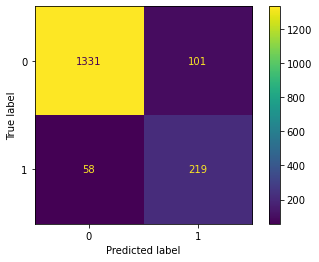

In [15]:
plot_confusion_matrix(SVM_grid.best_estimator_, tfidf_test, y_test)

## Grid LR

In [16]:
default_grid_LR = LogisticRegression(penalty='l2', dual=False, C=1, class_weight=None, 
                                solver='lbfgs', random_state=12)

# dictionary containing the parameters which will be used for grid search
grid_search_params={'penalty': ['l1', 'l2', 'elasticnet'],  
              'dual': [True, False], 
              'C': [1, 10, 30],
              'class_weight': [None, 'balanced'],
              'solver': ['newton-cg', 'lbfgs', 'sag', 'saga', 'liblinear']}

# grid search with f1 being the performance metric
grid_LR = GridSearchCV(default_grid_LR, grid_search_params, cv=5, scoring='f1_macro', verbose=3)
grid_LR.fit(tfidf_train, y_train)

Fitting 5 folds for each of 180 candidates, totalling 900 fits
[CV] C=1, class_weight=None, dual=True, penalty=l1, solver=newton-cg .
[CV]  C=1, class_weight=None, dual=True, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=1, class_weight=None, dual=True, penalty=l1, solver=newton-cg .
[CV]  C=1, class_weight=None, dual=True, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=1, class_weight=None, dual=True, penalty=l1, solver=newton-cg .
[CV]  C=1, class_weight=None, dual=True, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=1, class_weight=None, dual=True, penalty=l1, solver=newton-cg .
[CV]  C=1, class_weight=None, dual=True, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=1, class_weight=None, dual=True, penalty=l1, solver=newton-cg .
[CV]  C=1, class_weight=None, dual=True, penalty=l1, solver=newton-cg, score=nan, total=   0.0s
[CV] C=1, class_weight=None, dual=True, penalty=l1, solver=lbfgs .....
[CV]  C=1, class_weight=None, d

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\Jack\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Jack\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Jack\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Jack\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this 

[CV]  C=1, class_weight=None, dual=True, penalty=l2, solver=liblinear, score=0.645, total=   0.0s
[CV] C=1, class_weight=None, dual=True, penalty=elasticnet, solver=newton-cg 
[CV]  C=1, class_weight=None, dual=True, penalty=elasticnet, solver=newton-cg, score=nan, total=   0.0s
[CV] C=1, class_weight=None, dual=True, penalty=elasticnet, solver=newton-cg 
[CV]  C=1, class_weight=None, dual=True, penalty=elasticnet, solver=newton-cg, score=nan, total=   0.0s
[CV] C=1, class_weight=None, dual=True, penalty=elasticnet, solver=newton-cg 
[CV]  C=1, class_weight=None, dual=True, penalty=elasticnet, solver=newton-cg, score=nan, total=   0.0s
[CV] C=1, class_weight=None, dual=True, penalty=elasticnet, solver=newton-cg 
[CV]  C=1, class_weight=None, dual=True, penalty=elasticnet, solver=newton-cg, score=nan, total=   0.0s
[CV] C=1, class_weight=None, dual=True, penalty=elasticnet, solver=newton-cg 
[CV]  C=1, class_weight=None, dual=True, penalty=elasticnet, solver=newton-cg, score=nan, total=

C:\Users\Jack\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Jack\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Jack\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Jack\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got elasticnet penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\Jack\anaconda3\lib\site-packages\sklearn\model_selec

[CV]  C=1, class_weight=None, dual=False, penalty=l1, solver=saga, score=0.741, total=   0.1s
[CV] C=1, class_weight=None, dual=False, penalty=l1, solver=saga .....


C:\Users\Jack\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  C=1, class_weight=None, dual=False, penalty=l1, solver=saga, score=0.778, total=   0.2s
[CV] C=1, class_weight=None, dual=False, penalty=l1, solver=saga .....
[CV]  C=1, class_weight=None, dual=False, penalty=l1, solver=saga, score=0.772, total=   0.2s
[CV] C=1, class_weight=None, dual=False, penalty=l1, solver=saga .....
[CV]  C=1, class_weight=None, dual=False, penalty=l1, solver=saga, score=0.759, total=   0.1s
[CV] C=1, class_weight=None, dual=False, penalty=l1, solver=saga .....
[CV]  C=1, class_weight=None, dual=False, penalty=l1, solver=saga, score=0.744, total=   0.2s
[CV] C=1, class_weight=None, dual=False, penalty=l1, solver=liblinear 
[CV]  C=1, class_weight=None, dual=False, penalty=l1, solver=liblinear, score=0.741, total=   0.0s
[CV] C=1, class_weight=None, dual=False, penalty=l1, solver=liblinear 
[CV]  C=1, class_weight=None, dual=False, penalty=l1, solver=liblinear, score=0.781, total=   0.0s
[CV] C=1, class_weight=None, dual=False, penalty=l1, solver=liblinear 


C:\Users\Jack\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Jack\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Jack\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Jack\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got elasticnet penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\Jack\anaconda3\lib\site-packages\sklearn\model_selec


[CV] C=1, class_weight=None, dual=False, penalty=elasticnet, solver=sag 
[CV]  C=1, class_weight=None, dual=False, penalty=elasticnet, solver=sag, score=nan, total=   0.0s
[CV] C=1, class_weight=None, dual=False, penalty=elasticnet, solver=sag 
[CV]  C=1, class_weight=None, dual=False, penalty=elasticnet, solver=sag, score=nan, total=   0.0s
[CV] C=1, class_weight=None, dual=False, penalty=elasticnet, solver=sag 
[CV]  C=1, class_weight=None, dual=False, penalty=elasticnet, solver=sag, score=nan, total=   0.0s
[CV] C=1, class_weight=None, dual=False, penalty=elasticnet, solver=sag 
[CV]  C=1, class_weight=None, dual=False, penalty=elasticnet, solver=sag, score=nan, total=   0.0s
[CV] C=1, class_weight=None, dual=False, penalty=elasticnet, solver=sag 
[CV]  C=1, class_weight=None, dual=False, penalty=elasticnet, solver=sag, score=nan, total=   0.0s
[CV] C=1, class_weight=None, dual=False, penalty=elasticnet, solver=saga 
[CV]  C=1, class_weight=None, dual=False, penalty=elasticnet, sol

C:\Users\Jack\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Jack\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Jack\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Jack\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 445, in _check_solver
    raise ValueError("Solver %s supports only "
ValueError: Solver sag supports only dual=False, got dual=True

  warnings.warn("Estimator fit failed. The score on this train-test"



[CV] C=1, class_weight=balanced, dual=True, penalty=l2, solver=saga ..
[CV]  C=1, class_weight=balanced, dual=True, penalty=l2, solver=saga, score=nan, total=   0.0s
[CV] C=1, class_weight=balanced, dual=True, penalty=l2, solver=saga ..
[CV]  C=1, class_weight=balanced, dual=True, penalty=l2, solver=saga, score=nan, total=   0.0s
[CV] C=1, class_weight=balanced, dual=True, penalty=l2, solver=liblinear 
[CV]  C=1, class_weight=balanced, dual=True, penalty=l2, solver=liblinear, score=0.815, total=   0.0s
[CV] C=1, class_weight=balanced, dual=True, penalty=l2, solver=liblinear 
[CV]  C=1, class_weight=balanced, dual=True, penalty=l2, solver=liblinear, score=0.824, total=   0.0s
[CV] C=1, class_weight=balanced, dual=True, penalty=l2, solver=liblinear 
[CV]  C=1, class_weight=balanced, dual=True, penalty=l2, solver=liblinear, score=0.826, total=   0.0s
[CV] C=1, class_weight=balanced, dual=True, penalty=l2, solver=liblinear 
[CV]  C=1, class_weight=balanced, dual=True, penalty=l2, solver=l

C:\Users\Jack\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  C=1, class_weight=balanced, dual=False, penalty=l1, solver=saga, score=0.803, total=   0.3s
[CV] C=1, class_weight=balanced, dual=False, penalty=l1, solver=saga .


C:\Users\Jack\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  C=1, class_weight=balanced, dual=False, penalty=l1, solver=saga, score=0.813, total=   0.3s
[CV] C=1, class_weight=balanced, dual=False, penalty=l1, solver=saga .


C:\Users\Jack\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  C=1, class_weight=balanced, dual=False, penalty=l1, solver=saga, score=0.822, total=   0.3s
[CV] C=1, class_weight=balanced, dual=False, penalty=l1, solver=saga .


C:\Users\Jack\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  C=1, class_weight=balanced, dual=False, penalty=l1, solver=saga, score=0.783, total=   0.3s
[CV] C=1, class_weight=balanced, dual=False, penalty=l1, solver=saga .


C:\Users\Jack\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  C=1, class_weight=balanced, dual=False, penalty=l1, solver=saga, score=0.796, total=   0.3s
[CV] C=1, class_weight=balanced, dual=False, penalty=l1, solver=liblinear 
[CV]  C=1, class_weight=balanced, dual=False, penalty=l1, solver=liblinear, score=0.802, total=   0.0s
[CV] C=1, class_weight=balanced, dual=False, penalty=l1, solver=liblinear 
[CV]  C=1, class_weight=balanced, dual=False, penalty=l1, solver=liblinear, score=0.809, total=   0.0s
[CV] C=1, class_weight=balanced, dual=False, penalty=l1, solver=liblinear 
[CV]  C=1, class_weight=balanced, dual=False, penalty=l1, solver=liblinear, score=0.821, total=   0.0s
[CV] C=1, class_weight=balanced, dual=False, penalty=l1, solver=liblinear 
[CV]  C=1, class_weight=balanced, dual=False, penalty=l1, solver=liblinear, score=0.783, total=   0.0s
[CV] C=1, class_weight=balanced, dual=False, penalty=l1, solver=liblinear 
[CV]  C=1, class_weight=balanced, dual=False, penalty=l1, solver=liblinear, score=0.795, total=   0.0s
[CV] C=1, cl

C:\Users\Jack\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Jack\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Jack\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Jack\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got elasticnet penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\Jack\anaconda3\lib\site-packages\sklearn\model_selec

[CV]  C=10, class_weight=None, dual=True, penalty=l1, solver=saga, score=nan, total=   0.0s
[CV] C=10, class_weight=None, dual=True, penalty=l1, solver=saga .....
[CV]  C=10, class_weight=None, dual=True, penalty=l1, solver=saga, score=nan, total=   0.0s
[CV] C=10, class_weight=None, dual=True, penalty=l1, solver=liblinear 
[CV]  C=10, class_weight=None, dual=True, penalty=l1, solver=liblinear, score=nan, total=   0.0s
[CV] C=10, class_weight=None, dual=True, penalty=l1, solver=liblinear 
[CV]  C=10, class_weight=None, dual=True, penalty=l1, solver=liblinear, score=nan, total=   0.0s
[CV] C=10, class_weight=None, dual=True, penalty=l1, solver=liblinear 
[CV]  C=10, class_weight=None, dual=True, penalty=l1, solver=liblinear, score=nan, total=   0.0s
[CV] C=10, class_weight=None, dual=True, penalty=l1, solver=liblinear 
[CV]  C=10, class_weight=None, dual=True, penalty=l1, solver=liblinear, score=nan, total=   0.0s
[CV] C=10, class_weight=None, dual=True, penalty=l1, solver=liblinear 
[C

C:\Users\Jack\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  C=10, class_weight=None, dual=False, penalty=l1, solver=saga, score=0.788, total=   1.6s
[CV] C=10, class_weight=None, dual=False, penalty=l1, solver=saga ....


C:\Users\Jack\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  C=10, class_weight=None, dual=False, penalty=l1, solver=saga, score=0.806, total=   1.8s
[CV] C=10, class_weight=None, dual=False, penalty=l1, solver=saga ....


C:\Users\Jack\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  C=10, class_weight=None, dual=False, penalty=l1, solver=saga, score=0.764, total=   2.4s
[CV] C=10, class_weight=None, dual=False, penalty=l1, solver=saga ....


C:\Users\Jack\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  C=10, class_weight=None, dual=False, penalty=l1, solver=saga, score=0.787, total=   2.0s
[CV] C=10, class_weight=None, dual=False, penalty=l1, solver=saga ....


C:\Users\Jack\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  C=10, class_weight=None, dual=False, penalty=l1, solver=saga, score=0.777, total=   1.7s
[CV] C=10, class_weight=None, dual=False, penalty=l1, solver=liblinear 


C:\Users\Jack\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV]  C=10, class_weight=None, dual=False, penalty=l1, solver=liblinear, score=0.793, total=   6.0s
[CV] C=10, class_weight=None, dual=False, penalty=l1, solver=liblinear 
[CV]  C=10, class_weight=None, dual=False, penalty=l1, solver=liblinear, score=0.806, total=   6.3s
[CV] C=10, class_weight=None, dual=False, penalty=l1, solver=liblinear 
[CV]  C=10, class_weight=None, dual=False, penalty=l1, solver=liblinear, score=0.767, total=   7.5s
[CV] C=10, class_weight=None, dual=False, penalty=l1, solver=liblinear 
[CV]  C=10, class_weight=None, dual=False, penalty=l1, solver=liblinear, score=0.790, total=   5.1s
[CV] C=10, class_weight=None, dual=False, penalty=l1, solver=liblinear 
[CV]  C=10, class_weight=None, dual=False, penalty=l1, solver=liblinear, score=0.768, total=   0.0s
[CV] C=10, class_weight=None, dual=False, penalty=l2, solver=newton-cg 
[CV]  C=10, class_weight=None, dual=False, penalty=l2, solver=newton-cg, score=0.742, total=   0.1s
[CV] C=10, class_weight=None, dual=False

C:\Users\Jack\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Jack\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Jack\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Jack\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got elasticnet penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\Jack\anaconda3\lib\site-packages\sklearn\model_selec

[CV]  C=10, class_weight=balanced, dual=True, penalty=l2, solver=lbfgs, score=nan, total=   0.0s
[CV] C=10, class_weight=balanced, dual=True, penalty=l2, solver=lbfgs 
[CV]  C=10, class_weight=balanced, dual=True, penalty=l2, solver=lbfgs, score=nan, total=   0.0s
[CV] C=10, class_weight=balanced, dual=True, penalty=l2, solver=lbfgs 
[CV]  C=10, class_weight=balanced, dual=True, penalty=l2, solver=lbfgs, score=nan, total=   0.0s
[CV] C=10, class_weight=balanced, dual=True, penalty=l2, solver=lbfgs 
[CV]  C=10, class_weight=balanced, dual=True, penalty=l2, solver=lbfgs, score=nan, total=   0.0s
[CV] C=10, class_weight=balanced, dual=True, penalty=l2, solver=lbfgs 
[CV]  C=10, class_weight=balanced, dual=True, penalty=l2, solver=lbfgs, score=nan, total=   0.0s
[CV] C=10, class_weight=balanced, dual=True, penalty=l2, solver=sag ..
[CV]  C=10, class_weight=balanced, dual=True, penalty=l2, solver=sag, score=nan, total=   0.0s
[CV] C=10, class_weight=balanced, dual=True, penalty=l2, solver=s

C:\Users\Jack\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "



[CV] C=10, class_weight=balanced, dual=True, penalty=l2, solver=liblinear 
[CV]  C=10, class_weight=balanced, dual=True, penalty=l2, solver=liblinear, score=0.799, total=   0.0s
[CV] C=10, class_weight=balanced, dual=True, penalty=l2, solver=liblinear 
[CV]  C=10, class_weight=balanced, dual=True, penalty=l2, solver=liblinear, score=0.781, total=   0.0s
[CV] C=10, class_weight=balanced, dual=True, penalty=elasticnet, solver=newton-cg 
[CV]  C=10, class_weight=balanced, dual=True, penalty=elasticnet, solver=newton-cg, score=nan, total=   0.0s
[CV] C=10, class_weight=balanced, dual=True, penalty=elasticnet, solver=newton-cg 
[CV]  C=10, class_weight=balanced, dual=True, penalty=elasticnet, solver=newton-cg, score=nan, total=   0.0s
[CV] C=10, class_weight=balanced, dual=True, penalty=elasticnet, solver=newton-cg 
[CV]  C=10, class_weight=balanced, dual=True, penalty=elasticnet, solver=newton-cg, score=nan, total=   0.0s
[CV] C=10, class_weight=balanced, dual=True, penalty=elasticnet, so

C:\Users\Jack\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  C=10, class_weight=balanced, dual=False, penalty=l1, solver=saga, score=0.819, total=   1.5s
[CV] C=10, class_weight=balanced, dual=False, penalty=l1, solver=saga 


C:\Users\Jack\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  C=10, class_weight=balanced, dual=False, penalty=l1, solver=saga, score=0.831, total=   1.5s
[CV] C=10, class_weight=balanced, dual=False, penalty=l1, solver=saga 


C:\Users\Jack\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  C=10, class_weight=balanced, dual=False, penalty=l1, solver=saga, score=0.795, total=   1.5s
[CV] C=10, class_weight=balanced, dual=False, penalty=l1, solver=saga 


C:\Users\Jack\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  C=10, class_weight=balanced, dual=False, penalty=l1, solver=saga, score=0.817, total=   1.5s
[CV] C=10, class_weight=balanced, dual=False, penalty=l1, solver=saga 


C:\Users\Jack\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  C=10, class_weight=balanced, dual=False, penalty=l1, solver=saga, score=0.791, total=   1.4s
[CV] C=10, class_weight=balanced, dual=False, penalty=l1, solver=liblinear 
[CV]  C=10, class_weight=balanced, dual=False, penalty=l1, solver=liblinear, score=0.828, total=   0.0s
[CV] C=10, class_weight=balanced, dual=False, penalty=l1, solver=liblinear 
[CV]  C=10, class_weight=balanced, dual=False, penalty=l1, solver=liblinear, score=0.828, total=   0.0s
[CV] C=10, class_weight=balanced, dual=False, penalty=l1, solver=liblinear 


C:\Users\Jack\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV]  C=10, class_weight=balanced, dual=False, penalty=l1, solver=liblinear, score=0.793, total=   4.5s
[CV] C=10, class_weight=balanced, dual=False, penalty=l1, solver=liblinear 
[CV]  C=10, class_weight=balanced, dual=False, penalty=l1, solver=liblinear, score=0.811, total=   0.0s
[CV] C=10, class_weight=balanced, dual=False, penalty=l1, solver=liblinear 
[CV]  C=10, class_weight=balanced, dual=False, penalty=l1, solver=liblinear, score=0.784, total=   4.1s
[CV] C=10, class_weight=balanced, dual=False, penalty=l2, solver=newton-cg 
[CV]  C=10, class_weight=balanced, dual=False, penalty=l2, solver=newton-cg, score=0.811, total=   0.1s
[CV] C=10, class_weight=balanced, dual=False, penalty=l2, solver=newton-cg 
[CV]  C=10, class_weight=balanced, dual=False, penalty=l2, solver=newton-cg, score=0.817, total=   0.1s
[CV] C=10, class_weight=balanced, dual=False, penalty=l2, solver=newton-cg 
[CV]  C=10, class_weight=balanced, dual=False, penalty=l2, solver=newton-cg, score=0.813, total=   0

C:\Users\Jack\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Jack\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Jack\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Jack\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got elasticnet penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\Jack\anaconda3\lib\site-packages\sklearn\model_selec

[CV] C=30, class_weight=None, dual=True, penalty=l1, solver=liblinear 
[CV]  C=30, class_weight=None, dual=True, penalty=l1, solver=liblinear, score=nan, total=   0.0s
[CV] C=30, class_weight=None, dual=True, penalty=l1, solver=liblinear 
[CV]  C=30, class_weight=None, dual=True, penalty=l1, solver=liblinear, score=nan, total=   0.0s
[CV] C=30, class_weight=None, dual=True, penalty=l1, solver=liblinear 
[CV]  C=30, class_weight=None, dual=True, penalty=l1, solver=liblinear, score=nan, total=   0.0s
[CV] C=30, class_weight=None, dual=True, penalty=l1, solver=liblinear 
[CV]  C=30, class_weight=None, dual=True, penalty=l1, solver=liblinear, score=nan, total=   0.0s
[CV] C=30, class_weight=None, dual=True, penalty=l2, solver=newton-cg 
[CV]  C=30, class_weight=None, dual=True, penalty=l2, solver=newton-cg, score=nan, total=   0.0s
[CV] C=30, class_weight=None, dual=True, penalty=l2, solver=newton-cg 
[CV]  C=30, class_weight=None, dual=True, penalty=l2, solver=newton-cg, score=nan, total=

C:\Users\Jack\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV]  C=30, class_weight=None, dual=True, penalty=l2, solver=liblinear, score=0.715, total=   0.0s
[CV] C=30, class_weight=None, dual=True, penalty=l2, solver=liblinear 
[CV]  C=30, class_weight=None, dual=True, penalty=l2, solver=liblinear, score=0.737, total=   0.0s
[CV] C=30, class_weight=None, dual=True, penalty=l2, solver=liblinear 
[CV]  C=30, class_weight=None, dual=True, penalty=l2, solver=liblinear, score=0.745, total=   0.0s
[CV] C=30, class_weight=None, dual=True, penalty=elasticnet, solver=newton-cg 
[CV]  C=30, class_weight=None, dual=True, penalty=elasticnet, solver=newton-cg, score=nan, total=   0.0s
[CV] C=30, class_weight=None, dual=True, penalty=elasticnet, solver=newton-cg 
[CV]  C=30, class_weight=None, dual=True, penalty=elasticnet, solver=newton-cg, score=nan, total=   0.0s
[CV] C=30, class_weight=None, dual=True, penalty=elasticnet, solver=newton-cg 
[CV]  C=30, class_weight=None, dual=True, penalty=elasticnet, solver=newton-cg, score=nan, total=   0.0s
[CV] C=30

C:\Users\Jack\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  C=30, class_weight=None, dual=False, penalty=l1, solver=saga, score=0.752, total=   2.8s
[CV] C=30, class_weight=None, dual=False, penalty=l1, solver=saga ....


C:\Users\Jack\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  C=30, class_weight=None, dual=False, penalty=l1, solver=saga, score=0.777, total=   2.8s
[CV] C=30, class_weight=None, dual=False, penalty=l1, solver=saga ....


C:\Users\Jack\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  C=30, class_weight=None, dual=False, penalty=l1, solver=saga, score=0.711, total=   2.8s
[CV] C=30, class_weight=None, dual=False, penalty=l1, solver=saga ....


C:\Users\Jack\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  C=30, class_weight=None, dual=False, penalty=l1, solver=saga, score=0.751, total=   2.8s
[CV] C=30, class_weight=None, dual=False, penalty=l1, solver=saga ....


C:\Users\Jack\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  C=30, class_weight=None, dual=False, penalty=l1, solver=saga, score=0.768, total=   2.6s
[CV] C=30, class_weight=None, dual=False, penalty=l1, solver=liblinear 
[CV]  C=30, class_weight=None, dual=False, penalty=l1, solver=liblinear, score=0.734, total=   0.0s
[CV] C=30, class_weight=None, dual=False, penalty=l1, solver=liblinear 
[CV]  C=30, class_weight=None, dual=False, penalty=l1, solver=liblinear, score=0.745, total=   0.0s
[CV] C=30, class_weight=None, dual=False, penalty=l1, solver=liblinear 
[CV]  C=30, class_weight=None, dual=False, penalty=l1, solver=liblinear, score=0.698, total=   0.0s
[CV] C=30, class_weight=None, dual=False, penalty=l1, solver=liblinear 
[CV]  C=30, class_weight=None, dual=False, penalty=l1, solver=liblinear, score=0.718, total=   0.0s
[CV] C=30, class_weight=None, dual=False, penalty=l1, solver=liblinear 
[CV]  C=30, class_weight=None, dual=False, penalty=l1, solver=liblinear, score=0.779, total=   0.0s
[CV] C=30, class_weight=None, dual=False, pen

C:\Users\Jack\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Jack\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

[CV]  C=30, class_weight=None, dual=False, penalty=l2, solver=lbfgs, score=0.745, total=   0.2s
[CV] C=30, class_weight=None, dual=False, penalty=l2, solver=lbfgs ...
[CV]  C=30, class_weight=None, dual=False, penalty=l2, solver=lbfgs, score=0.765, total=   0.2s
[CV] C=30, class_weight=None, dual=False, penalty=l2, solver=lbfgs ...


C:\Users\Jack\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV]  C=30, class_weight=None, dual=False, penalty=l2, solver=lbfgs, score=0.715, total=   1.7s
[CV] C=30, class_weight=None, dual=False, penalty=l2, solver=lbfgs ...
[CV]  C=30, class_weight=None, dual=False, penalty=l2, solver=lbfgs, score=0.737, total=   0.2s
[CV] C=30, class_weight=None, dual=False, penalty=l2, solver=lbfgs ...


C:\Users\Jack\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV]  C=30, class_weight=None, dual=False, penalty=l2, solver=lbfgs, score=0.745, total=   0.2s
[CV] C=30, class_weight=None, dual=False, penalty=l2, solver=sag .....
[CV]  C=30, class_weight=None, dual=False, penalty=l2, solver=sag, score=0.745, total=   0.1s
[CV] C=30, class_weight=None, dual=False, penalty=l2, solver=sag .....
[CV]  C=30, class_weight=None, dual=False, penalty=l2, solver=sag, score=0.765, total=   0.1s
[CV] C=30, class_weight=None, dual=False, penalty=l2, solver=sag .....
[CV]  C=30, class_weight=None, dual=False, penalty=l2, solver=sag, score=0.715, total=   0.1s
[CV] C=30, class_weight=None, dual=False, penalty=l2, solver=sag .....
[CV]  C=30, class_weight=None, dual=False, penalty=l2, solver=sag, score=0.737, total=   0.1s
[CV] C=30, class_weight=None, dual=False, penalty=l2, solver=sag .....
[CV]  C=30, class_weight=None, dual=False, penalty=l2, solver=sag, score=0.745, total=   0.1s
[CV] C=30, class_weight=None, dual=False, penalty=l2, solver=saga ....


C:\Users\Jack\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Jack\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Jack\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  C=30, class_weight=None, dual=False, penalty=l2, solver=saga, score=0.745, total=   0.1s
[CV] C=30, class_weight=None, dual=False, penalty=l2, solver=saga ....
[CV]  C=30, class_weight=None, dual=False, penalty=l2, solver=saga, score=0.771, total=   0.1s
[CV] C=30, class_weight=None, dual=False, penalty=l2, solver=saga ....
[CV]  C=30, class_weight=None, dual=False, penalty=l2, solver=saga, score=0.724, total=   0.1s
[CV] C=30, class_weight=None, dual=False, penalty=l2, solver=saga ....
[CV]  C=30, class_weight=None, dual=False, penalty=l2, solver=saga, score=0.740, total=   0.1s
[CV] C=30, class_weight=None, dual=False, penalty=l2, solver=saga ....


C:\Users\Jack\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Jack\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  C=30, class_weight=None, dual=False, penalty=l2, solver=saga, score=0.748, total=   0.1s
[CV] C=30, class_weight=None, dual=False, penalty=l2, solver=liblinear 
[CV]  C=30, class_weight=None, dual=False, penalty=l2, solver=liblinear, score=0.745, total=   0.0s
[CV] C=30, class_weight=None, dual=False, penalty=l2, solver=liblinear 
[CV]  C=30, class_weight=None, dual=False, penalty=l2, solver=liblinear, score=0.765, total=   0.0s
[CV] C=30, class_weight=None, dual=False, penalty=l2, solver=liblinear 
[CV]  C=30, class_weight=None, dual=False, penalty=l2, solver=liblinear, score=0.715, total=   0.0s
[CV] C=30, class_weight=None, dual=False, penalty=l2, solver=liblinear 
[CV]  C=30, class_weight=None, dual=False, penalty=l2, solver=liblinear, score=0.737, total=   0.0s
[CV] C=30, class_weight=None, dual=False, penalty=l2, solver=liblinear 
[CV]  C=30, class_weight=None, dual=False, penalty=l2, solver=liblinear, score=0.745, total=   0.0s
[CV] C=30, class_weight=None, dual=False, pen

C:\Users\Jack\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Jack\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Jack\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Jack\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got elasticnet penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\Jack\anaconda3\lib\site-packages\sklearn\model_selec

[CV]  C=30, class_weight=None, dual=False, penalty=elasticnet, solver=sag, score=nan, total=   0.0s
[CV] C=30, class_weight=None, dual=False, penalty=elasticnet, solver=sag 
[CV]  C=30, class_weight=None, dual=False, penalty=elasticnet, solver=sag, score=nan, total=   0.0s
[CV] C=30, class_weight=None, dual=False, penalty=elasticnet, solver=saga 
[CV]  C=30, class_weight=None, dual=False, penalty=elasticnet, solver=saga, score=nan, total=   0.0s
[CV] C=30, class_weight=None, dual=False, penalty=elasticnet, solver=saga 
[CV]  C=30, class_weight=None, dual=False, penalty=elasticnet, solver=saga, score=nan, total=   0.0s
[CV] C=30, class_weight=None, dual=False, penalty=elasticnet, solver=saga 
[CV]  C=30, class_weight=None, dual=False, penalty=elasticnet, solver=saga, score=nan, total=   0.0s
[CV] C=30, class_weight=None, dual=False, penalty=elasticnet, solver=saga 
[CV]  C=30, class_weight=None, dual=False, penalty=elasticnet, solver=saga, score=nan, total=   0.0s
[CV] C=30, class_weigh

C:\Users\Jack\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV]  C=30, class_weight=balanced, dual=True, penalty=l2, solver=liblinear, score=0.801, total=   0.0s
[CV] C=30, class_weight=balanced, dual=True, penalty=l2, solver=liblinear 
[CV]  C=30, class_weight=balanced, dual=True, penalty=l2, solver=liblinear, score=0.810, total=   0.0s
[CV] C=30, class_weight=balanced, dual=True, penalty=l2, solver=liblinear 
[CV]  C=30, class_weight=balanced, dual=True, penalty=l2, solver=liblinear, score=0.785, total=   0.0s
[CV] C=30, class_weight=balanced, dual=True, penalty=l2, solver=liblinear 
[CV]  C=30, class_weight=balanced, dual=True, penalty=l2, solver=liblinear, score=0.795, total=   0.0s
[CV] C=30, class_weight=balanced, dual=True, penalty=l2, solver=liblinear 
[CV]  C=30, class_weight=balanced, dual=True, penalty=l2, solver=liblinear, score=0.774, total=   0.0s
[CV] C=30, class_weight=balanced, dual=True, penalty=elasticnet, solver=newton-cg 
[CV]  C=30, class_weight=balanced, dual=True, penalty=elasticnet, solver=newton-cg, score=nan, total= 

C:\Users\Jack\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  C=30, class_weight=balanced, dual=False, penalty=l1, solver=saga, score=0.799, total=   2.6s
[CV] C=30, class_weight=balanced, dual=False, penalty=l1, solver=saga 


C:\Users\Jack\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  C=30, class_weight=balanced, dual=False, penalty=l1, solver=saga, score=0.817, total=   2.5s
[CV] C=30, class_weight=balanced, dual=False, penalty=l1, solver=saga 


C:\Users\Jack\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  C=30, class_weight=balanced, dual=False, penalty=l1, solver=saga, score=0.768, total=   2.5s
[CV] C=30, class_weight=balanced, dual=False, penalty=l1, solver=saga 


C:\Users\Jack\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  C=30, class_weight=balanced, dual=False, penalty=l1, solver=saga, score=0.782, total=   2.6s
[CV] C=30, class_weight=balanced, dual=False, penalty=l1, solver=saga 


C:\Users\Jack\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  C=30, class_weight=balanced, dual=False, penalty=l1, solver=saga, score=0.785, total=   2.3s
[CV] C=30, class_weight=balanced, dual=False, penalty=l1, solver=liblinear 
[CV]  C=30, class_weight=balanced, dual=False, penalty=l1, solver=liblinear, score=0.768, total=   0.0s
[CV] C=30, class_weight=balanced, dual=False, penalty=l1, solver=liblinear 
[CV]  C=30, class_weight=balanced, dual=False, penalty=l1, solver=liblinear, score=0.803, total=   0.0s
[CV] C=30, class_weight=balanced, dual=False, penalty=l1, solver=liblinear 
[CV]  C=30, class_weight=balanced, dual=False, penalty=l1, solver=liblinear, score=0.755, total=   0.0s
[CV] C=30, class_weight=balanced, dual=False, penalty=l1, solver=liblinear 


C:\Users\Jack\anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[CV]  C=30, class_weight=balanced, dual=False, penalty=l1, solver=liblinear, score=0.785, total=   6.4s
[CV] C=30, class_weight=balanced, dual=False, penalty=l1, solver=liblinear 
[CV]  C=30, class_weight=balanced, dual=False, penalty=l1, solver=liblinear, score=0.774, total=   4.4s
[CV] C=30, class_weight=balanced, dual=False, penalty=l2, solver=newton-cg 
[CV]  C=30, class_weight=balanced, dual=False, penalty=l2, solver=newton-cg, score=0.801, total=   0.1s
[CV] C=30, class_weight=balanced, dual=False, penalty=l2, solver=newton-cg 
[CV]  C=30, class_weight=balanced, dual=False, penalty=l2, solver=newton-cg, score=0.810, total=   0.1s
[CV] C=30, class_weight=balanced, dual=False, penalty=l2, solver=newton-cg 
[CV]  C=30, class_weight=balanced, dual=False, penalty=l2, solver=newton-cg, score=0.785, total=   0.1s
[CV] C=30, class_weight=balanced, dual=False, penalty=l2, solver=newton-cg 
[CV]  C=30, class_weight=balanced, dual=False, penalty=l2, solver=newton-cg, score=0.795, total=   0

C:\Users\Jack\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Jack\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i 

[CV]  C=30, class_weight=balanced, dual=False, penalty=l2, solver=lbfgs, score=0.801, total=   0.2s
[CV] C=30, class_weight=balanced, dual=False, penalty=l2, solver=lbfgs 
[CV]  C=30, class_weight=balanced, dual=False, penalty=l2, solver=lbfgs, score=0.810, total=   0.2s
[CV] C=30, class_weight=balanced, dual=False, penalty=l2, solver=lbfgs 
[CV]  C=30, class_weight=balanced, dual=False, penalty=l2, solver=lbfgs, score=0.785, total=   0.2s
[CV] C=30, class_weight=balanced, dual=False, penalty=l2, solver=lbfgs 
[CV]  C=30, class_weight=balanced, dual=False, penalty=l2, solver=lbfgs, score=0.795, total=   0.2s
[CV] C=30, class_weight=balanced, dual=False, penalty=l2, solver=lbfgs 


C:\Users\Jack\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV]  C=30, class_weight=balanced, dual=False, penalty=l2, solver=lbfgs, score=0.772, total=   0.2s
[CV] C=30, class_weight=balanced, dual=False, penalty=l2, solver=sag .
[CV]  C=30, class_weight=balanced, dual=False, penalty=l2, solver=sag, score=0.801, total=   0.1s
[CV] C=30, class_weight=balanced, dual=False, penalty=l2, solver=sag .
[CV]  C=30, class_weight=balanced, dual=False, penalty=l2, solver=sag, score=0.810, total=   0.1s
[CV] C=30, class_weight=balanced, dual=False, penalty=l2, solver=sag .
[CV]  C=30, class_weight=balanced, dual=False, penalty=l2, solver=sag, score=0.785, total=   0.1s
[CV] C=30, class_weight=balanced, dual=False, penalty=l2, solver=sag .
[CV]  C=30, class_weight=balanced, dual=False, penalty=l2, solver=sag, score=0.795, total=   0.1s
[CV] C=30, class_weight=balanced, dual=False, penalty=l2, solver=sag .
[CV]  C=30, class_weight=balanced, dual=False, penalty=l2, solver=sag, score=0.772, total=   0.1s
[CV] C=30, class_weight=balanced, dual=False, penalty=l

C:\Users\Jack\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Jack\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Jack\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  C=30, class_weight=balanced, dual=False, penalty=l2, solver=saga, score=0.801, total=   0.1s
[CV] C=30, class_weight=balanced, dual=False, penalty=l2, solver=saga 
[CV]  C=30, class_weight=balanced, dual=False, penalty=l2, solver=saga, score=0.810, total=   0.1s
[CV] C=30, class_weight=balanced, dual=False, penalty=l2, solver=saga 
[CV]  C=30, class_weight=balanced, dual=False, penalty=l2, solver=saga, score=0.787, total=   0.1s
[CV] C=30, class_weight=balanced, dual=False, penalty=l2, solver=saga 
[CV]  C=30, class_weight=balanced, dual=False, penalty=l2, solver=saga, score=0.795, total=   0.1s
[CV] C=30, class_weight=balanced, dual=False, penalty=l2, solver=saga 


C:\Users\Jack\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\Jack\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


[CV]  C=30, class_weight=balanced, dual=False, penalty=l2, solver=saga, score=0.775, total=   0.1s
[CV] C=30, class_weight=balanced, dual=False, penalty=l2, solver=liblinear 
[CV]  C=30, class_weight=balanced, dual=False, penalty=l2, solver=liblinear, score=0.801, total=   0.0s
[CV] C=30, class_weight=balanced, dual=False, penalty=l2, solver=liblinear 
[CV]  C=30, class_weight=balanced, dual=False, penalty=l2, solver=liblinear, score=0.810, total=   0.0s
[CV] C=30, class_weight=balanced, dual=False, penalty=l2, solver=liblinear 
[CV]  C=30, class_weight=balanced, dual=False, penalty=l2, solver=liblinear, score=0.785, total=   0.0s
[CV] C=30, class_weight=balanced, dual=False, penalty=l2, solver=liblinear 
[CV]  C=30, class_weight=balanced, dual=False, penalty=l2, solver=liblinear, score=0.795, total=   0.0s
[CV] C=30, class_weight=balanced, dual=False, penalty=l2, solver=liblinear 
[CV]  C=30, class_weight=balanced, dual=False, penalty=l2, solver=liblinear, score=0.774, total=   0.0s
[

C:\Users\Jack\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Jack\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Jack\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Jack\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got elasticnet penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\Jack\anaconda3\lib\site-packages\sklearn\model_selec

[CV]  C=30, class_weight=balanced, dual=False, penalty=elasticnet, solver=saga, score=nan, total=   0.0s
[CV] C=30, class_weight=balanced, dual=False, penalty=elasticnet, solver=saga 
[CV]  C=30, class_weight=balanced, dual=False, penalty=elasticnet, solver=saga, score=nan, total=   0.0s
[CV] C=30, class_weight=balanced, dual=False, penalty=elasticnet, solver=liblinear 
[CV]  C=30, class_weight=balanced, dual=False, penalty=elasticnet, solver=liblinear, score=nan, total=   0.0s
[CV] C=30, class_weight=balanced, dual=False, penalty=elasticnet, solver=liblinear 
[CV]  C=30, class_weight=balanced, dual=False, penalty=elasticnet, solver=liblinear, score=nan, total=   0.0s
[CV] C=30, class_weight=balanced, dual=False, penalty=elasticnet, solver=liblinear 
[CV]  C=30, class_weight=balanced, dual=False, penalty=elasticnet, solver=liblinear, score=nan, total=   0.0s
[CV] C=30, class_weight=balanced, dual=False, penalty=elasticnet, solver=liblinear 
[CV]  C=30, class_weight=balanced, dual=False

C:\Users\Jack\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


GridSearchCV(cv=5, estimator=LogisticRegression(C=1, random_state=12),
             param_grid={'C': [1, 10, 30], 'class_weight': [None, 'balanced'],
                         'dual': [True, False],
                         'penalty': ['l1', 'l2', 'elasticnet'],
                         'solver': ['newton-cg', 'lbfgs', 'sag', 'saga',
                                    'liblinear']},
             scoring='f1_macro', verbose=3)

In [17]:
# train classifier
print("training...")
grid_LR.best_estimator_.fit(tfidf_train, y_train)
print("complete.")
# use classifier to predict on test set
print("predicting...")
LR_test_preds = grid_LR.best_estimator_.predict(tfidf_test)
print("complete.")

training...
complete.
predicting...
complete.


C:\Users\Jack\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [19]:
grid_LR_precision = precision_score(y_test, LR_test_preds)
grid_LR_recall = recall_score(y_test, LR_test_preds)
grid_LR_macro_f1_score = f1_score(y_test, LR_test_preds, average='macro')

#model evaluation
print('Model evaluation metrics')
print('Precision: {:.3}'.format(grid_LR_precision))
print('Recall: {:.3}'.format(grid_LR_recall))
print('Macro F1 Score: {:.3}'.format(grid_LR_macro_f1_score))

TFIDF_metrics['Grid LR'] = {'precision': grid_LR_precision, 'recall': grid_LR_recall, 
                            'macro_f1': grid_LR_macro_f1_score}

Model evaluation metrics
Precision: 0.708
Recall: 0.718
Macro F1 Score: 0.829


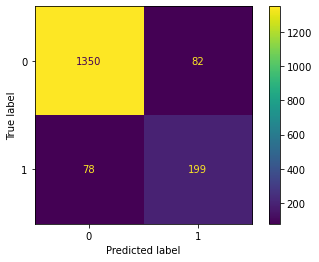

In [20]:
plot_confusion_matrix(grid_LR, tfidf_test, y_test)

## Grid NB

In [21]:
grid_NB = GaussianNB()

grid_search_params = {'var_smoothing': np.logspace(0,-9, num=100)}
grid_NB = GridSearchCV(grid_NB, grid_search_params, cv=5, scoring='f1_macro', verbose=3)

grid_NB.fit(tfidf_train.toarray(), y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] var_smoothing=1.0 ...............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................... var_smoothing=1.0, score=0.623, total=   2.8s
[CV] var_smoothing=1.0 ...............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.8s remaining:    0.0s


[CV] ................... var_smoothing=1.0, score=0.682, total=   2.5s
[CV] var_smoothing=1.0 ...............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.4s remaining:    0.0s


[CV] ................... var_smoothing=1.0, score=0.639, total=   1.5s
[CV] var_smoothing=1.0 ...............................................
[CV] ................... var_smoothing=1.0, score=0.607, total=   1.5s
[CV] var_smoothing=1.0 ...............................................
[CV] ................... var_smoothing=1.0, score=0.568, total=   1.3s
[CV] var_smoothing=0.8111308307896871 ................................
[CV] .... var_smoothing=0.8111308307896871, score=0.473, total=   0.9s
[CV] var_smoothing=0.8111308307896871 ................................
[CV] .... var_smoothing=0.8111308307896871, score=0.548, total=   0.8s
[CV] var_smoothing=0.8111308307896871 ................................
[CV] .... var_smoothing=0.8111308307896871, score=0.494, total=   0.9s
[CV] var_smoothing=0.8111308307896871 ................................
[CV] .... var_smoothing=0.8111308307896871, score=0.461, total=   0.8s
[CV] var_smoothing=0.8111308307896871 ................................
[CV] .

[CV] ... var_smoothing=0.08111308307896872, score=0.427, total=   0.8s
[CV] var_smoothing=0.08111308307896872 ...............................
[CV] ... var_smoothing=0.08111308307896872, score=0.468, total=   0.9s
[CV] var_smoothing=0.08111308307896872 ...............................
[CV] ... var_smoothing=0.08111308307896872, score=0.433, total=   0.9s
[CV] var_smoothing=0.08111308307896872 ...............................
[CV] ... var_smoothing=0.08111308307896872, score=0.411, total=   0.8s
[CV] var_smoothing=0.08111308307896872 ...............................
[CV] ... var_smoothing=0.08111308307896872, score=0.399, total=   0.8s
[CV] var_smoothing=0.0657933224657568 ................................
[CV] .... var_smoothing=0.0657933224657568, score=0.435, total=   0.8s
[CV] var_smoothing=0.0657933224657568 ................................
[CV] .... var_smoothing=0.0657933224657568, score=0.482, total=   0.8s
[CV] var_smoothing=0.0657933224657568 ................................
[CV] .

[CV] .. var_smoothing=0.008111308307896872, score=0.544, total=   0.8s
[CV] var_smoothing=0.008111308307896872 ..............................
[CV] .. var_smoothing=0.008111308307896872, score=0.561, total=   0.9s
[CV] var_smoothing=0.006579332246575682 ..............................
[CV] .. var_smoothing=0.006579332246575682, score=0.579, total=   0.9s
[CV] var_smoothing=0.006579332246575682 ..............................
[CV] .. var_smoothing=0.006579332246575682, score=0.593, total=   0.9s
[CV] var_smoothing=0.006579332246575682 ..............................
[CV] .. var_smoothing=0.006579332246575682, score=0.580, total=   0.9s
[CV] var_smoothing=0.006579332246575682 ..............................
[CV] .. var_smoothing=0.006579332246575682, score=0.552, total=   0.9s
[CV] var_smoothing=0.006579332246575682 ..............................
[CV] .. var_smoothing=0.006579332246575682, score=0.568, total=   0.8s
[CV] var_smoothing=0.005336699231206307 ..............................
[CV] .

[CV] . var_smoothing=0.0006579332246575676, score=0.628, total=   0.9s
[CV] var_smoothing=0.0006579332246575676 .............................
[CV] . var_smoothing=0.0006579332246575676, score=0.604, total=   0.8s
[CV] var_smoothing=0.0006579332246575676 .............................
[CV] . var_smoothing=0.0006579332246575676, score=0.582, total=   0.8s
[CV] var_smoothing=0.0006579332246575676 .............................
[CV] . var_smoothing=0.0006579332246575676, score=0.604, total=   0.8s
[CV] var_smoothing=0.0005336699231206307 .............................
[CV] . var_smoothing=0.0005336699231206307, score=0.590, total=   0.9s
[CV] var_smoothing=0.0005336699231206307 .............................
[CV] . var_smoothing=0.0005336699231206307, score=0.628, total=   0.8s
[CV] var_smoothing=0.0005336699231206307 .............................
[CV] . var_smoothing=0.0005336699231206307, score=0.602, total=   0.8s
[CV] var_smoothing=0.0005336699231206307 .............................
[CV] .

[CV] . var_smoothing=6.579332246575683e-05, score=0.602, total=   0.9s
[CV] var_smoothing=5.3366992312063123e-05 ............................
[CV]  var_smoothing=5.3366992312063123e-05, score=0.576, total=   0.9s
[CV] var_smoothing=5.3366992312063123e-05 ............................
[CV]  var_smoothing=5.3366992312063123e-05, score=0.626, total=   1.0s
[CV] var_smoothing=5.3366992312063123e-05 ............................
[CV]  var_smoothing=5.3366992312063123e-05, score=0.603, total=   1.0s
[CV] var_smoothing=5.3366992312063123e-05 ............................
[CV]  var_smoothing=5.3366992312063123e-05, score=0.573, total=   0.9s
[CV] var_smoothing=5.3366992312063123e-05 ............................
[CV]  var_smoothing=5.3366992312063123e-05, score=0.602, total=   1.6s
[CV] var_smoothing=4.328761281083062e-05 .............................
[CV] . var_smoothing=4.328761281083062e-05, score=0.577, total=   1.3s
[CV] var_smoothing=4.328761281083062e-05 .............................
[CV] .

[CV] . var_smoothing=5.336699231206313e-06, score=0.604, total=   0.8s
[CV] var_smoothing=5.336699231206313e-06 .............................
[CV] . var_smoothing=5.336699231206313e-06, score=0.569, total=   0.9s
[CV] var_smoothing=5.336699231206313e-06 .............................
[CV] . var_smoothing=5.336699231206313e-06, score=0.602, total=   0.9s
[CV] var_smoothing=4.328761281083053e-06 .............................
[CV] . var_smoothing=4.328761281083053e-06, score=0.577, total=   0.8s
[CV] var_smoothing=4.328761281083053e-06 .............................
[CV] . var_smoothing=4.328761281083053e-06, score=0.622, total=   0.9s
[CV] var_smoothing=4.328761281083053e-06 .............................
[CV] . var_smoothing=4.328761281083053e-06, score=0.604, total=   0.9s
[CV] var_smoothing=4.328761281083053e-06 .............................
[CV] . var_smoothing=4.328761281083053e-06, score=0.569, total=   0.8s
[CV] var_smoothing=4.328761281083053e-06 .............................
[CV] .

[CV]  var_smoothing=4.3287612810830526e-07, score=0.577, total=   0.8s
[CV] var_smoothing=4.3287612810830526e-07 ............................
[CV]  var_smoothing=4.3287612810830526e-07, score=0.622, total=   0.8s
[CV] var_smoothing=4.3287612810830526e-07 ............................
[CV]  var_smoothing=4.3287612810830526e-07, score=0.604, total=   0.8s
[CV] var_smoothing=4.3287612810830526e-07 ............................
[CV]  var_smoothing=4.3287612810830526e-07, score=0.569, total=   0.8s
[CV] var_smoothing=4.3287612810830526e-07 ............................
[CV]  var_smoothing=4.3287612810830526e-07, score=0.602, total=   0.9s
[CV] var_smoothing=3.5111917342151277e-07 ............................
[CV]  var_smoothing=3.5111917342151277e-07, score=0.577, total=   0.9s
[CV] var_smoothing=3.5111917342151277e-07 ............................
[CV]  var_smoothing=3.5111917342151277e-07, score=0.622, total=   0.8s
[CV] var_smoothing=3.5111917342151277e-07 ............................
[CV]  

[CV]  var_smoothing=4.3287612810830526e-08, score=0.569, total=   0.8s
[CV] var_smoothing=4.3287612810830526e-08 ............................
[CV]  var_smoothing=4.3287612810830526e-08, score=0.602, total=   0.9s
[CV] var_smoothing=3.5111917342151277e-08 ............................
[CV]  var_smoothing=3.5111917342151277e-08, score=0.577, total=   0.9s
[CV] var_smoothing=3.5111917342151277e-08 ............................
[CV]  var_smoothing=3.5111917342151277e-08, score=0.622, total=   0.8s
[CV] var_smoothing=3.5111917342151277e-08 ............................
[CV]  var_smoothing=3.5111917342151277e-08, score=0.604, total=   0.8s
[CV] var_smoothing=3.5111917342151277e-08 ............................
[CV]  var_smoothing=3.5111917342151277e-08, score=0.569, total=   0.8s
[CV] var_smoothing=3.5111917342151277e-08 ............................
[CV]  var_smoothing=3.5111917342151277e-08, score=0.602, total=   0.8s
[CV] var_smoothing=2.848035868435799e-08 .............................
[CV] .

[CV]  var_smoothing=3.5111917342151273e-09, score=0.622, total=   0.8s
[CV] var_smoothing=3.5111917342151273e-09 ............................
[CV]  var_smoothing=3.5111917342151273e-09, score=0.604, total=   0.8s
[CV] var_smoothing=3.5111917342151273e-09 ............................
[CV]  var_smoothing=3.5111917342151273e-09, score=0.569, total=   0.8s
[CV] var_smoothing=3.5111917342151273e-09 ............................
[CV]  var_smoothing=3.5111917342151273e-09, score=0.602, total=   0.8s
[CV] var_smoothing=2.848035868435805e-09 .............................
[CV] . var_smoothing=2.848035868435805e-09, score=0.577, total=   0.9s
[CV] var_smoothing=2.848035868435805e-09 .............................
[CV] . var_smoothing=2.848035868435805e-09, score=0.622, total=   0.8s
[CV] var_smoothing=2.848035868435805e-09 .............................
[CV] . var_smoothing=2.848035868435805e-09, score=0.604, total=   0.8s
[CV] var_smoothing=2.848035868435805e-09 .............................
[CV] .

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  7.8min finished


GridSearchCV(cv=5, estimator=GaussianNB(),
             param_grid={'var_smoothing': array([1.00000000e+00, 8.11130831e-01, 6.57933225e-01, 5.33669923e-01,
       4.32876128e-01, 3.51119173e-01, 2.84803587e-01, 2.31012970e-01,
       1.87381742e-01, 1.51991108e-01, 1.23284674e-01, 1.00000000e-01,
       8.11130831e-02, 6.57933225e-02, 5.33669923e-02, 4.32876128e-02,
       3.51119173e-02, 2.84803587e-02, 2.31...
       1.23284674e-07, 1.00000000e-07, 8.11130831e-08, 6.57933225e-08,
       5.33669923e-08, 4.32876128e-08, 3.51119173e-08, 2.84803587e-08,
       2.31012970e-08, 1.87381742e-08, 1.51991108e-08, 1.23284674e-08,
       1.00000000e-08, 8.11130831e-09, 6.57933225e-09, 5.33669923e-09,
       4.32876128e-09, 3.51119173e-09, 2.84803587e-09, 2.31012970e-09,
       1.87381742e-09, 1.51991108e-09, 1.23284674e-09, 1.00000000e-09])},
             scoring='f1_macro', verbose=3)

In [22]:
# train classifier
print("training...")
grid_NB.best_estimator_.fit(tfidf_train.toarray(), y_train)
print("complete.")
# use classifier to predict on test set
print("predicting...")
NB_test_preds = grid_NB.best_estimator_.predict(tfidf_test.toarray())
print("complete.")

training...
complete.
predicting...
complete.


In [23]:
grid_NB_precision = precision_score(y_test, NB_test_preds)
grid_NB_recall = recall_score(y_test, NB_test_preds)
grid_NB_macro_f1_score = f1_score(y_test, NB_test_preds, average='macro')

#model evaluation
print('Model evaluation metrics')
print('Precision: {:.3}'.format(grid_NB_precision))
print('Recall: {:.3}'.format(grid_NB_recall))
print('Macro F1 Score: {:.3}'.format(grid_NB_macro_f1_score))

TFIDF_metrics['Grid NB'] = {'precision': grid_NB_precision, 'recall': grid_NB_recall, 
                            'macro_f1': grid_NB_macro_f1_score}

Model evaluation metrics
Precision: 0.394
Recall: 0.924
Macro F1 Score: 0.693


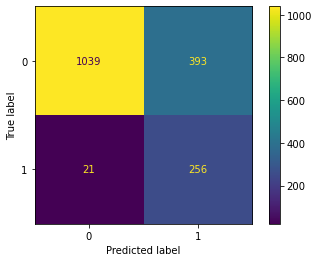

In [24]:
plot_confusion_matrix(grid_NB, tfidf_test.toarray(), y_test)

## Results

In [28]:
#compare parameters
TFIDF_results = pd.DataFrame.from_dict(TFIDF_metrics, orient='index')
#TFIDF_results.to_csv(r"C:\Users\jackc\Semester2\Project\Identifying-Hate-Speech-Categories-On-Social-Media\Results\TFIDF_results",
               #index=False)

In [29]:
TFIDF_results

,precision,recall,macro_f1
Default SVM,0.684375,0.790614,0.838653
Grid LR,0.708185,0.718412,0.828659
Grid NB,0.394453,0.924188,0.693392


## Word2Vec

In [19]:
%%time
def get_vec(x):
  doc = nlp(x)
  return doc.vector

doc2vec_dataset = df.drop(['id','tokenized_text','text_lemma', 'pos_tags'],axis = 1).copy()

doc2vec_dataset['vec'] = doc2vec_dataset['text'].apply(lambda x: get_vec(x))

doc2vec_dataset.head()

Wall time: 44.5 s


,text,Annotation,Hate,vec
0,i just found the perfect rental why cant my le...,Neither,0,"[0.0547106, 0.22135, -0.23980302, -0.15787779,..."
1,every time they discover anything its either ...,Neither,0,"[-0.057143338, 0.14135154, -0.27148843, 0.0042..."
2,ok time to write code bbl\n\nmaking a new thing,Neither,0,"[0.0057974537, 0.13553664, -0.23749961, -0.046..."
3,refined dessert not mkr,Neither,0,"[-0.13199374, 0.09915501, 0.08181499, -0.27303..."
4,one of the best things anyone can do to impr...,Neither,0,"[-0.047892362, 0.08786684, -0.20262949, -0.039..."


In [20]:
# load the model from disk
default_SVM = pickle.load(open('default_svm.sav', 'rb'))
#grid_SVM = pickle.load(open('grid_svm.sav', 'rb'))
grid_SVM = svm.SVC(C=10, class_weight='balanced', coef0=1, degree=5, gamma=0.01, kernel='poly',
    random_state=12)

In [21]:
XX = doc2vec_dataset['vec'].to_numpy()
XX = XX.reshape(-1,1)
XX = np.concatenate(np.concatenate(XX,axis = 0),axis = 0).reshape(-1,300)
XX.shape

(6836, 300)

In [22]:
yy = doc2vec_dataset['Hate']

In [23]:
%%time

lr1 = LogisticRegression(max_iter=100)

accuracy = []
skf = StratifiedKFold(n_splits=10)
skf.get_n_splits(XX, yy)
for clf in (lr1,default_SVM, grid_SVM):

    StratifiedKFold(n_splits=10, random_state=None, shuffle=False)
    for train_index, test_index in skf.split(XX, yy):
            
            X1_train, X1_test = XX[train_index], XX[test_index]
            y1_train, y1_test = yy[train_index], yy[test_index]

            model = clf.fit(X1_train,y1_train)
            y_preds = model.predict(X1_test)
            acc = (sklearn.metrics.f1_score(y1_test,y_preds,average = 'micro'))
            accuracy.append(acc)
    print(clf.__class__.__name__,np.array(accuracy).mean())

LogisticRegression 0.8794589573005231
SVC 0.8848706686188385
SVC 0.8752653555150278
Wall time: 2min


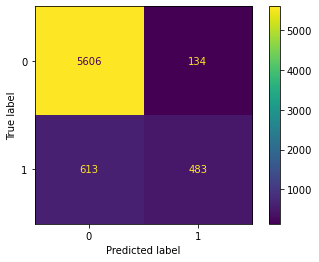

In [24]:
plot_confusion_matrix(lr1, XX, yy)

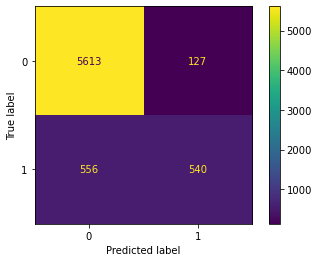

In [25]:
plot_confusion_matrix(default_SVM, XX, yy)

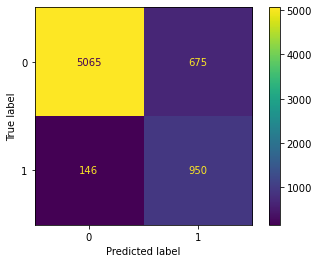

In [26]:
plot_confusion_matrix(grid_SVM, XX, yy)

In [40]:
#Load in data and split for train and test sets
X_train, X_test, y_train, y_test = train_test_split(XX, yy, test_size=0.3, random_state=12)

In [41]:
SVM_default = svm.SVC(C=1.0, kernel='rbf', gamma='scale', shrinking=True,
                      class_weight=None, random_state=12)

# train classifier
print("training...")
SVM_default.fit(X_train, y_train)
print("complete.")
# use classifier to predict on test set
print("predicting...")
SVM_test_preds = SVM_default.predict(X_test)
print("complete.")

training...
complete.
predicting...
complete.


In [42]:
SVM_metrics = {}
SVM_default_precision = precision_score(y_test, SVM_test_preds)
SVM_default_recall = recall_score(y_test, SVM_test_preds)
SVM_default_f1_score = f1_score(y_test, SVM_test_preds)
SVM_default_weighted_f1_score = f1_score(y_test, SVM_test_preds, average='weighted')

#model evaluation
print('Model evaluation metrics')
print('Precision: {:.3}'.format(SVM_default_precision))
print('Recall: {:.3}'.format(SVM_default_recall))
print('F1 Score: {:.3}'.format(SVM_default_f1_score))
print('Weighted F1 Score: {:.3}'.format(SVM_default_weighted_f1_score))

SVM_metrics['Default SVM'] = {'precision': SVM_default_precision, 'recall': SVM_default_recall, 
                                  'f1_score': SVM_default_f1_score, 'weighted_f1': SVM_default_weighted_f1_score}

Model evaluation metrics
Precision: 0.827
Recall: 0.467
F1 Score: 0.597
Weighted F1 Score: 0.884


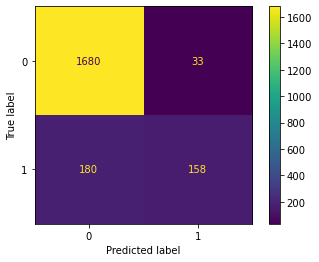

In [43]:
plot_confusion_matrix(SVM_default, X_test, y_test)